### Regression using CatBoost 

This dataset is avaliable on

http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant


The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. 

Features consist of hourly average ambient variables 
1. Temperature (AT)
2. Exhaust Vacuum (V) 
3. Ambient Pressure (AP)
4. Relative Humidity (RH) 
5. hourly electrical energy output (EP) --> Prediction

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.

For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measurements are used for statistical testing.

###### Soulution:
Training a xgboost regression on provided data after combining all five shffled sheets

In [1]:
# inputs
datapath = './CCPP/'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error
import catboost as cb
from catboost import Pool, CatBoostRegressor


print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('sklearn:', pd.__version__)
print('catboost:', cb.__version__)

%matplotlib inline

pandas: 0.21.0
numpy: 1.13.3
sklearn: 0.21.0
catboost: 0.1.1.9


In [3]:
# read data sets
df = pd.read_excel(datapath + 'Folds5x2_pp.xlsx',sheet_name=['Sheet1','Sheet2','Sheet3','Sheet4','Sheet5'])
df = pd.concat(df).reset_index()
df.drop(['level_0','level_1'],axis=1,inplace=True)

df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [4]:
# Sampling
trainx, valx, trainy, valy = train_test_split(df.drop(['PE'],axis=1),df['PE'],test_size=.3,random_state =2017)

In [5]:
# Define categorical features here
cat_f = []

In [6]:
# Creating dmatrix for training and validation
if len(cat_f) == 0:
    dtrain = Pool(data=trainx,label=trainy)
    dval = Pool(data=valx,label=valy)
else :
    dtrain = Pool(data=trainx,label=trainy,cat_features=cat_f)
    dval = Pool(data=valx,label=valy,cat_features=cat_f)    

In [7]:
# defining xgb parameters
parms = {'loss_function': 'RMSE', 
         'iterations': 10000,
         'depth' : 6,
         'learning_rate': 1,
         'l2_leaf_reg': 20,
         'rsm': .9, # The percentage of features to use at each iteration of building trees.
         'eval_metric' : 'RMSE'# ,'verbose': True}
        }

# Cross validation
cv_cab = cb.cv(params = parms, 
                pool = dtrain,
                fold_count=3,
               enable_early_stopping =True) # Look for early stopping that minimizes error

cv_cab = pd.DataFrame(cv_cab)

cv_cab.tail(10)

,b'RMSE'_test_avg,b'RMSE'_test_stddev,b'RMSE'_train_avg,b'RMSE'_train_stddev
9990,1.727897,0.241815,1.171176,0.218293
9991,1.727860,0.241788,1.171166,0.218305
9992,1.727862,0.241842,1.171160,0.218309
9993,1.727943,0.241810,1.171125,0.218272
9994,1.727942,0.241853,1.171103,0.218258
9995,1.727948,0.241916,1.171094,0.218259
9996,1.727932,0.241876,1.171081,0.218252
9997,1.727864,0.241886,1.170962,0.218126
9998,1.727861,0.241900,1.170959,0.218124
9999,1.727860,0.241906,1.170918,0.218187


In [8]:
cb_mdl = CatBoostRegressor(loss_function= 'RMSE', 
                         iterations = 10000,
                         depth = 6,
                         learning_rate = 1,
                         l2_leaf_reg =  20,
                         rsm = .9, # The percentage of features to use at each iteration of building trees.
                         eval_metric = 'RMSE'
        )

cb_mdl.fit(dtrain,eval_set=dval,verbose=True,use_best_model=True,plot=True)

Borders for float features generated
0:	learn 16.04918949	test 17.20614647	bestTest 17.20614647		total: 24.4ms	remaining: 4m 3s
1:	learn 9.568187626	test 9.873394045	bestTest 9.873394045		total: 49.2ms	remaining: 4m 5s
2:	learn 8.219068865	test 8.547461121	bestTest 8.547461121		total: 70.5ms	remaining: 3m 55s
3:	learn 7.827369672	test 8.040837728	bestTest 8.040837728		total: 91.7ms	remaining: 3m 49s
4:	learn 7.565952823	test 7.763255124	bestTest 7.763255124		total: 109ms	remaining: 3m 38s
5:	learn 6.566855855	test 6.722577798	bestTest 6.722577798		total: 131ms	remaining: 3m 38s
6:	learn 6.433480613	test 6.594089468	bestTest 6.594089468		total: 150ms	remaining: 3m 34s
7:	learn 6.393773739	test 6.517869885	bestTest 6.517869885		total: 171ms	remaining: 3m 33s
8:	learn 6.276726085	test 6.35602589	bestTest 6.35602589		total: 192ms	remaining: 3m 33s
9:	learn 6.149272363	test 6.179415177	bestTest 6.179415177		total: 211ms	remaining: 3m 30s
10:	learn 5.981970207	test 6.034817912	bestTest 6.034

CatboostIpythonWidget(data={'.': {'path': '.', 'name': 'current', 'content': {'passed_iterations': 52, 'total_iterations': 10000, 'rows': {'learn_error': [['iter', 'RMSE'], ['0', '16.04918949'], ['1', '9.568187626'], ['2', '8.219068865'], ['3', '7.827369672'], ['4', '7.565952823'], ['5', '6.566855855'], ['6', '6.433480613'], ['7', '6.393773739'], ['8', '6.276726085'], ['9', '6.149272363'], ['10', '5.981970207'], ['11', '5.897744979'], ['12', '5.520971744'], ['13', '5.452603067'], ['14', '5.368190377'], ['15', '5.349719543'], ['16', '5.120448268'], ['17', '5.109450678'], ['18', '5.087494785'], ['19', '4.794693112'], ['20', '4.788352336'], ['21', '4.78744257'], ['22', '4.78090951'], ['23', '4.702417371'], ['24', '4.700771001'], ['25', '4.66762204'], ['26', '4.61641085'], ['27', '4.612302641'], ['28', '4.517572852'], ['29', '4.500510235'], ['30', '4.492170796'], ['31', '4.491216289'], ['32', '4.491131029'], ['33', '4.474770596'], ['34', '4.474577318'], ['35', '4.474548982'], ['36', '4.474394438'], ['37', '4.47439142'], ['38', '4.464607144'], ['39', '4.464494812'], ['40', '4.461578665'], ['41', '4.455366938'], ['42', '4.434991995'], ['43', '4.40095032'], ['44', '4.400013696'], ['45', '4.399227731'], ['46', '4.375352687'], ['47', '4.353137761'], ['48', '4.347593564'], ['49', '4.344917299'], ['50', '4.33473049'], ['51', '4.328667404'], ['52', '4.328665673']], 'test_error': [['iter', 'RMSE'], ['0', '17.20614647'], ['1', '9.873394045'], ['2', '8.547461121'], ['3', '8.040837728'], ['4', '7.763255124'], ['5', '6.722577798'], ['6', '6.594089468'], ['7', '6.517869885'], ['8', '6.35602589'], ['9', '6.179415177'], ['10', '6.034817912'], ['11', '5.999734415'], ['12', '5.636901615'], ['13', '5.568054096'], ['14', '5.497636416'], ['15', '5.474658199'], ['16', '5.173131392'], ['17', '5.162309888'], ['18', '5.141594705'], ['19', '4.883533188'], ['20', '4.87122777'], ['21', '4.86875118'], ['22', '4.863647929'], ['23', '4.788903973'], ['24', '4.787138507'], ['25', '4.745237488'], ['26', '4.68781295'], ['27', '4.685277527'], ['28', '4.582259'], ['29', '4.573904042'], ['30', '4.561045535'], ['31', '4.558728546'], ['32', '4.558323979'], ['33', '4.546184543'], ['34', '4.54488118'], ['35', '4.544714427'], ['36', '4.544323621'], ['37', '4.544120203'], ['38', '4.536827348'], ['39', '4.535779428'], ['40', '4.531246178'], ['41', '4.526666175'], ['42', '4.503701359'], ['43', '4.466842868'], ['44', '4.465912816'], ['45', '4.465658999'], ['46', '4.443987185'], ['47', '4.425067395'], ['48', '4.420966494'], ['49', '4.415319021'], ['50', '4.401885449'], ['51', '4.399798815']], 'time_left': [['0', '243898', '24'], ['1', '245898', '49'], ['2', '235093', '70'], ['3', '229113', '91'], ['4', '218719', '109'], ['5', '218368', '131'], ['6', '214604', '150'], ['7', '213582', '171'], ['8', '213468', '192'], ['9', '210798', '211'], ['10', '214333', '236'], ['11', '211759', '254'], ['12', '209118', '272'], ['13', '206306', '289'], ['14', '203808', '306'], ['15', '201756', '323'], ['16', '199945', '340'], ['17', '198331', '357'], ['18', '196822', '374'], ['19', '195402', '391'], ['20', '195980', '412'], ['21', '195850', '431'], ['22', '194713', '448'], ['23', '193631', '465'], ['24', '192792', '483'], ['25', '191894', '500'], ['26', '191039', '517'], ['27', '190290', '534'], ['28', '189651', '551'], ['29', '189004', '568'], ['30', '188419', '585'], ['31', '188456', '604'], ['32', '188136', '622'], ['33', '187764', '640'], ['34', '185797', '652'], ['35', '184612', '667'], ['36', '183494', '681'], ['37', '181771', '693'], ['38', '181699', '711'], ['39', '179592', '721'], ['40', '179287', '738'], ['41', '179170', '755'], ['42', '179079', '773'], ['43', '178870', '790'], ['44', '178863', '808'], ['45', '178941', '826'], ['46', '179247', '846'], ['47', '179080', '863'], ['48', '178876', '880'], ['49', '178684', '897'], ['50', '178572', '915'], ['51', '179619', '938'], ['52', '177876', '947']], 'meta': {'name': 'experiment', 'iterCount': '10000', 'learnErrorLog': 'learn_error.tsv

learn 4.328655951	test 4.399841866	bestTest 4.399775882		total: 963ms	remaining: 2m 57s
54:	learn 4.325116207	test 4.395048197	bestTest 4.395048197		total: 995ms	remaining: 2m 59s
55:	learn 4.249202414	test 4.333237476	bestTest 4.333237476		total: 1.02s	remaining: 3m 1s
56:	learn 4.232585626	test 4.321348684	bestTest 4.321348684		total: 1.05s	remaining: 3m 2s
57:	learn 4.21363256	test 4.298136807	bestTest 4.298136807		total: 1.06s	remaining: 3m 2s
58:	learn 4.213622121	test 4.298187774	bestTest 4.298136807		total: 1.07s	remaining: 3m
59:	learn 4.213016091	test 4.296532273	bestTest 4.296532273		total: 1.09s	remaining: 3m
60:	learn 4.191536808	test 4.27669361	bestTest 4.27669361		total: 1.11s	remaining: 3m
61:	learn 4.188423862	test 4.274081745	bestTest 4.274081745		total: 1.13s	remaining: 3m
62:	learn 4.188412045	test 4.273774693	bestTest 4.273774693		total: 1.14s	remaining: 2m 59s
63:	learn 4.188392101	test 4.273865573	bestTest 4.273774693		total: 1.15s	remaining: 2m 58s
64:	learn 4.14

146:	learn 3.767512291	test 3.891997768	bestTest 3.891997768		total: 2.49s	remaining: 2m 46s
147:	learn 3.76748675	test 3.891906398	bestTest 3.891906398		total: 2.5s	remaining: 2m 46s
148:	learn 3.767474917	test 3.891814803	bestTest 3.891814803		total: 2.52s	remaining: 2m 46s
149:	learn 3.767474917	test 3.891814587	bestTest 3.891814587		total: 2.52s	remaining: 2m 45s
150:	learn 3.767474916	test 3.891814532	bestTest 3.891814532		total: 2.53s	remaining: 2m 45s
151:	learn 3.763250848	test 3.888654405	bestTest 3.888654405		total: 2.55s	remaining: 2m 45s
152:	learn 3.760463259	test 3.88898937	bestTest 3.888654405		total: 2.57s	remaining: 2m 45s
153:	learn 3.760057247	test 3.888290888	bestTest 3.888290888		total: 2.58s	remaining: 2m 45s
154:	learn 3.760054775	test 3.888287216	bestTest 3.888287216		total: 2.6s	remaining: 2m 45s
155:	learn 3.760020866	test 3.888499144	bestTest 3.888287216		total: 2.61s	remaining: 2m 44s
156:	learn 3.760019186	test 3.888444229	bestTest 3.888287216		total: 2.62s

240:	learn 3.412796968	test 3.547422351	bestTest 3.547422351		total: 3.96s	remaining: 2m 40s
241:	learn 3.410854936	test 3.54525525	bestTest 3.54525525		total: 3.98s	remaining: 2m 40s
242:	learn 3.410854927	test 3.54525498	bestTest 3.54525498		total: 3.99s	remaining: 2m 40s
243:	learn 3.410220958	test 3.544189628	bestTest 3.544189628		total: 4.01s	remaining: 2m 40s
244:	learn 3.404888659	test 3.538902021	bestTest 3.538902021		total: 4.02s	remaining: 2m 40s
245:	learn 3.400377984	test 3.533004115	bestTest 3.533004115		total: 4.04s	remaining: 2m 40s
246:	learn 3.400375922	test 3.53304018	bestTest 3.533004115		total: 4.05s	remaining: 2m 39s
247:	learn 3.395663086	test 3.528291674	bestTest 3.528291674		total: 4.07s	remaining: 2m 39s
248:	learn 3.395370428	test 3.528278998	bestTest 3.528278998		total: 4.08s	remaining: 2m 40s
249:	learn 3.388412133	test 3.520503178	bestTest 3.520503178		total: 4.1s	remaining: 2m 40s
250:	learn 3.383418326	test 3.515182652	bestTest 3.515182652		total: 4.12s	r

335:	learn 3.170427439	test 3.326294028	bestTest 3.326294028		total: 5.55s	remaining: 2m 39s
336:	learn 3.170413613	test 3.326294055	bestTest 3.326294028		total: 5.56s	remaining: 2m 39s
337:	learn 3.168239754	test 3.323980413	bestTest 3.323980413		total: 5.58s	remaining: 2m 39s
338:	learn 3.166450867	test 3.322584144	bestTest 3.322584144		total: 5.6s	remaining: 2m 39s
339:	learn 3.165796554	test 3.321784961	bestTest 3.321784961		total: 5.61s	remaining: 2m 39s
340:	learn 3.16526649	test 3.32070438	bestTest 3.32070438		total: 5.63s	remaining: 2m 39s
341:	learn 3.164886237	test 3.320489047	bestTest 3.320489047		total: 5.65s	remaining: 2m 39s
342:	learn 3.164834307	test 3.320349369	bestTest 3.320349369		total: 5.67s	remaining: 2m 39s
343:	learn 3.16018846	test 3.317325477	bestTest 3.317325477		total: 5.68s	remaining: 2m 39s
344:	learn 3.160178667	test 3.317225533	bestTest 3.317225533		total: 5.7s	remaining: 2m 39s
345:	learn 3.15777779	test 3.315047563	bestTest 3.315047563		total: 5.71s	re

426:	learn 3.039565784	test 3.2176941	bestTest 3.2176941		total: 7.06s	remaining: 2m 38s
427:	learn 3.039496067	test 3.217462192	bestTest 3.217462192		total: 7.08s	remaining: 2m 38s
428:	learn 3.039492153	test 3.217421338	bestTest 3.217421338		total: 7.09s	remaining: 2m 38s
429:	learn 3.039474597	test 3.217504017	bestTest 3.217421338		total: 7.1s	remaining: 2m 37s
430:	learn 3.03848082	test 3.216809351	bestTest 3.216809351		total: 7.12s	remaining: 2m 38s
431:	learn 3.037225115	test 3.216291336	bestTest 3.216291336		total: 7.13s	remaining: 2m 38s
432:	learn 3.036273647	test 3.215200006	bestTest 3.215200006		total: 7.16s	remaining: 2m 38s
433:	learn 3.036273625	test 3.215198231	bestTest 3.215198231		total: 7.16s	remaining: 2m 37s
434:	learn 3.036273625	test 3.215198227	bestTest 3.215198227		total: 7.17s	remaining: 2m 37s
435:	learn 3.035308614	test 3.213322256	bestTest 3.213322256		total: 7.19s	remaining: 2m 37s
436:	learn 3.035286918	test 3.213423949	bestTest 3.213322256		total: 7.2s	re

521:	learn 2.880773994	test 3.082486277	bestTest 3.082486277		total: 8.52s	remaining: 2m 34s
522:	learn 2.880743795	test 3.08248987	bestTest 3.082486277		total: 8.54s	remaining: 2m 34s
523:	learn 2.879903679	test 3.081142819	bestTest 3.081142819		total: 8.56s	remaining: 2m 34s
524:	learn 2.879900309	test 3.081152462	bestTest 3.081142819		total: 8.56s	remaining: 2m 34s
525:	learn 2.879900309	test 3.081152517	bestTest 3.081142819		total: 8.57s	remaining: 2m 34s
526:	learn 2.875936608	test 3.074823946	bestTest 3.074823946		total: 8.59s	remaining: 2m 34s
527:	learn 2.873663486	test 3.073143927	bestTest 3.073143927		total: 8.6s	remaining: 2m 34s
528:	learn 2.866096512	test 3.067886532	bestTest 3.067886532		total: 8.62s	remaining: 2m 34s
529:	learn 2.863847615	test 3.067120341	bestTest 3.067120341		total: 8.64s	remaining: 2m 34s
530:	learn 2.863200853	test 3.067379826	bestTest 3.067120341		total: 8.65s	remaining: 2m 34s
531:	learn 2.86116282	test 3.064776432	bestTest 3.064776432		total: 8.67

614:	learn 2.742671435	test 2.955896654	bestTest 2.955896654		total: 9.98s	remaining: 2m 32s
615:	learn 2.742638555	test 2.955988535	bestTest 2.955896654		total: 10s	remaining: 2m 32s
616:	learn 2.739626005	test 2.954541155	bestTest 2.954541155		total: 10s	remaining: 2m 32s
617:	learn 2.739555885	test 2.954664445	bestTest 2.954541155		total: 10s	remaining: 2m 32s
618:	learn 2.739145287	test 2.954701449	bestTest 2.954541155		total: 10.1s	remaining: 2m 32s
619:	learn 2.738265659	test 2.953411339	bestTest 2.953411339		total: 10.1s	remaining: 2m 32s
620:	learn 2.735361709	test 2.950659242	bestTest 2.950659242		total: 10.1s	remaining: 2m 32s
621:	learn 2.734970342	test 2.950831579	bestTest 2.950659242		total: 10.1s	remaining: 2m 32s
622:	learn 2.734631905	test 2.950409554	bestTest 2.950409554		total: 10.1s	remaining: 2m 32s
623:	learn 2.734515913	test 2.950498283	bestTest 2.950409554		total: 10.1s	remaining: 2m 32s
624:	learn 2.73337223	test 2.95007444	bestTest 2.95007444		total: 10.2s	rema

707:	learn 2.634315961	test 2.864819266	bestTest 2.864819266		total: 11.6s	remaining: 2m 32s
708:	learn 2.634220526	test 2.864634128	bestTest 2.864634128		total: 11.6s	remaining: 2m 32s
709:	learn 2.63319081	test 2.863144367	bestTest 2.863144367		total: 11.6s	remaining: 2m 32s
710:	learn 2.631702741	test 2.861966552	bestTest 2.861966552		total: 11.6s	remaining: 2m 32s
711:	learn 2.63144249	test 2.861784304	bestTest 2.861784304		total: 11.7s	remaining: 2m 32s
712:	learn 2.631442483	test 2.861781474	bestTest 2.861781474		total: 11.7s	remaining: 2m 32s
713:	learn 2.631442483	test 2.86178147	bestTest 2.86178147		total: 11.7s	remaining: 2m 31s
714:	learn 2.630773083	test 2.861438145	bestTest 2.861438145		total: 11.7s	remaining: 2m 31s
715:	learn 2.629321348	test 2.859695239	bestTest 2.859695239		total: 11.7s	remaining: 2m 31s
716:	learn 2.62929243	test 2.859684279	bestTest 2.859684279		total: 11.7s	remaining: 2m 31s
717:	learn 2.628459579	test 2.859545389	bestTest 2.859545389		total: 11.7s	

805:	learn 2.553092491	test 2.795624823	bestTest 2.795624823		total: 13.3s	remaining: 2m 31s
806:	learn 2.551735997	test 2.794600868	bestTest 2.794600868		total: 13.3s	remaining: 2m 31s
807:	learn 2.551735668	test 2.794615674	bestTest 2.794600868		total: 13.3s	remaining: 2m 31s
808:	learn 2.550929204	test 2.793979226	bestTest 2.793979226		total: 13.3s	remaining: 2m 31s
809:	learn 2.550896373	test 2.793868144	bestTest 2.793868144		total: 13.3s	remaining: 2m 31s
810:	learn 2.548716999	test 2.791356538	bestTest 2.791356538		total: 13.3s	remaining: 2m 31s
811:	learn 2.548710536	test 2.791320824	bestTest 2.791320824		total: 13.3s	remaining: 2m 30s
812:	learn 2.548441996	test 2.791775799	bestTest 2.791320824		total: 13.4s	remaining: 2m 30s
813:	learn 2.548441591	test 2.791759279	bestTest 2.791320824		total: 13.4s	remaining: 2m 30s
814:	learn 2.547435344	test 2.791073874	bestTest 2.791073874		total: 13.4s	remaining: 2m 30s
815:	learn 2.545283551	test 2.789091079	bestTest 2.789091079		total: 1

903:	learn 2.469188497	test 2.720831271	bestTest 2.720831271		total: 14.7s	remaining: 2m 27s
904:	learn 2.469188314	test 2.720839133	bestTest 2.720831271		total: 14.7s	remaining: 2m 27s
905:	learn 2.467301897	test 2.719382789	bestTest 2.719382789		total: 14.7s	remaining: 2m 27s
906:	learn 2.466671124	test 2.719199694	bestTest 2.719199694		total: 14.7s	remaining: 2m 27s
907:	learn 2.466562294	test 2.718786568	bestTest 2.718786568		total: 14.8s	remaining: 2m 27s
908:	learn 2.465624118	test 2.718130179	bestTest 2.718130179		total: 14.8s	remaining: 2m 27s
909:	learn 2.465193871	test 2.717380945	bestTest 2.717380945		total: 14.8s	remaining: 2m 27s
910:	learn 2.465168658	test 2.717318035	bestTest 2.717318035		total: 14.8s	remaining: 2m 27s
911:	learn 2.464986181	test 2.717349759	bestTest 2.717318035		total: 14.8s	remaining: 2m 27s
912:	learn 2.464985338	test 2.717344426	bestTest 2.717318035		total: 14.8s	remaining: 2m 27s
913:	learn 2.464580269	test 2.717614805	bestTest 2.717318035		total: 1

995:	learn 2.420550576	test 2.680676343	bestTest 2.68048293		total: 16.2s	remaining: 2m 26s
996:	learn 2.420531692	test 2.680477381	bestTest 2.680477381		total: 16.2s	remaining: 2m 26s
997:	learn 2.419940926	test 2.680022015	bestTest 2.680022015		total: 16.2s	remaining: 2m 26s
998:	learn 2.418441132	test 2.679454515	bestTest 2.679454515		total: 16.2s	remaining: 2m 26s
999:	learn 2.417500103	test 2.678068012	bestTest 2.678068012		total: 16.2s	remaining: 2m 26s
1000:	learn 2.417391335	test 2.677952427	bestTest 2.677952427		total: 16.3s	remaining: 2m 26s
1001:	learn 2.417246356	test 2.677435314	bestTest 2.677435314		total: 16.3s	remaining: 2m 26s
1002:	learn 2.417246356	test 2.677435269	bestTest 2.677435269		total: 16.3s	remaining: 2m 26s
1003:	learn 2.417129145	test 2.677486062	bestTest 2.677435269		total: 16.3s	remaining: 2m 26s
1004:	learn 2.416910564	test 2.677663575	bestTest 2.677435269		total: 16.3s	remaining: 2m 26s
1005:	learn 2.416732516	test 2.677501034	bestTest 2.677435269		tot

1094:	learn 2.351330722	test 2.628394266	bestTest 2.628394266		total: 17.9s	remaining: 2m 25s
1095:	learn 2.351081832	test 2.628288958	bestTest 2.628288958		total: 17.9s	remaining: 2m 25s
1096:	learn 2.351081804	test 2.628285581	bestTest 2.628285581		total: 17.9s	remaining: 2m 25s
1097:	learn 2.351081804	test 2.628285576	bestTest 2.628285576		total: 17.9s	remaining: 2m 25s
1098:	learn 2.351081804	test 2.628285576	bestTest 2.628285576		total: 17.9s	remaining: 2m 25s
1099:	learn 2.349864759	test 2.628020087	bestTest 2.628020087		total: 17.9s	remaining: 2m 24s
1100:	learn 2.349239465	test 2.628062777	bestTest 2.628020087		total: 17.9s	remaining: 2m 24s
1101:	learn 2.346996212	test 2.629062412	bestTest 2.628020087		total: 18s	remaining: 2m 24s
1102:	learn 2.346656878	test 2.627819673	bestTest 2.627819673		total: 18s	remaining: 2m 24s
1103:	learn 2.346434757	test 2.627306616	bestTest 2.627306616		total: 18s	remaining: 2m 24s
1104:	learn 2.346393697	test 2.627338147	bestTest 2.627306616		tot

1183:	learn 2.280746854	test 2.578619966	bestTest 2.578619966		total: 19.3s	remaining: 2m 23s
1184:	learn 2.277025487	test 2.573909906	bestTest 2.573909906		total: 19.4s	remaining: 2m 23s
1185:	learn 2.276838454	test 2.573926678	bestTest 2.573909906		total: 19.4s	remaining: 2m 23s
1186:	learn 2.276808642	test 2.573911464	bestTest 2.573909906		total: 19.4s	remaining: 2m 23s
1187:	learn 2.276808573	test 2.573912418	bestTest 2.573909906		total: 19.5s	remaining: 2m 24s
1188:	learn 2.276808573	test 2.573912419	bestTest 2.573909906		total: 19.5s	remaining: 2m 24s
1189:	learn 2.276543907	test 2.573551669	bestTest 2.573551669		total: 19.5s	remaining: 2m 24s
1190:	learn 2.270282604	test 2.572352607	bestTest 2.572352607		total: 19.5s	remaining: 2m 24s
1191:	learn 2.268521588	test 2.572008491	bestTest 2.572008491		total: 19.5s	remaining: 2m 24s
1192:	learn 2.267637888	test 2.572035118	bestTest 2.572008491		total: 19.5s	remaining: 2m 24s
1193:	learn 2.265181249	test 2.571069756	bestTest 2.57106975

1272:	learn 2.222020441	test 2.529818848	bestTest 2.529818848		total: 20.8s	remaining: 2m 22s
1273:	learn 2.221202823	test 2.529420411	bestTest 2.529420411		total: 20.8s	remaining: 2m 22s
1274:	learn 2.22081548	test 2.528812512	bestTest 2.528812512		total: 20.8s	remaining: 2m 22s
1275:	learn 2.220517166	test 2.528592516	bestTest 2.528592516		total: 20.9s	remaining: 2m 22s
1276:	learn 2.220416768	test 2.528558837	bestTest 2.528558837		total: 20.9s	remaining: 2m 22s
1277:	learn 2.220405746	test 2.528483646	bestTest 2.528483646		total: 20.9s	remaining: 2m 22s
1278:	learn 2.216505622	test 2.525496419	bestTest 2.525496419		total: 20.9s	remaining: 2m 22s
1279:	learn 2.216482339	test 2.525425982	bestTest 2.525425982		total: 20.9s	remaining: 2m 22s
1280:	learn 2.215962036	test 2.525117966	bestTest 2.525117966		total: 21s	remaining: 2m 22s
1281:	learn 2.215911804	test 2.525152637	bestTest 2.525117966		total: 21s	remaining: 2m 22s
1282:	learn 2.215882161	test 2.524996278	bestTest 2.524996278		to

1360:	learn 2.18084824	test 2.493401859	bestTest 2.49311535		total: 22.3s	remaining: 2m 21s
1361:	learn 2.180263659	test 2.493496582	bestTest 2.49311535		total: 22.3s	remaining: 2m 21s
1362:	learn 2.180064863	test 2.493231097	bestTest 2.49311535		total: 22.3s	remaining: 2m 21s
1363:	learn 2.180052224	test 2.493191541	bestTest 2.49311535		total: 22.3s	remaining: 2m 21s
1364:	learn 2.180050426	test 2.493185524	bestTest 2.49311535		total: 22.4s	remaining: 2m 21s
1365:	learn 2.180010994	test 2.493202449	bestTest 2.49311535		total: 22.4s	remaining: 2m 21s
1366:	learn 2.179951302	test 2.493145535	bestTest 2.49311535		total: 22.4s	remaining: 2m 21s
1367:	learn 2.179696021	test 2.492653428	bestTest 2.492653428		total: 22.4s	remaining: 2m 21s
1368:	learn 2.179663421	test 2.492554038	bestTest 2.492554038		total: 22.4s	remaining: 2m 21s
1369:	learn 2.179663421	test 2.492553779	bestTest 2.492553779		total: 22.4s	remaining: 2m 21s
1370:	learn 2.179651802	test 2.492509901	bestTest 2.492509901		total

1455:	learn 2.143171757	test 2.456021377	bestTest 2.455999231		total: 23.9s	remaining: 2m 20s
1456:	learn 2.142941485	test 2.456344484	bestTest 2.455999231		total: 23.9s	remaining: 2m 20s
1457:	learn 2.142578875	test 2.455695653	bestTest 2.455695653		total: 24s	remaining: 2m 20s
1458:	learn 2.142090063	test 2.455303531	bestTest 2.455303531		total: 24s	remaining: 2m 20s
1459:	learn 2.142013055	test 2.4551893	bestTest 2.4551893		total: 24s	remaining: 2m 20s
1460:	learn 2.141774769	test 2.454997637	bestTest 2.454997637		total: 24s	remaining: 2m 20s
1461:	learn 2.138939562	test 2.454168263	bestTest 2.454168263		total: 24s	remaining: 2m 20s
1462:	learn 2.138925624	test 2.454159332	bestTest 2.454159332		total: 24s	remaining: 2m 20s
1463:	learn 2.137130392	test 2.452911114	bestTest 2.452911114		total: 24.1s	remaining: 2m 20s
1464:	learn 2.137053413	test 2.452835808	bestTest 2.452835808		total: 24.1s	remaining: 2m 20s
1465:	learn 2.136992974	test 2.452923934	bestTest 2.452835808		total: 24.1s	

1551:	learn 2.087907627	test 2.408082493	bestTest 2.408082493		total: 25.6s	remaining: 2m 19s
1552:	learn 2.087713125	test 2.407852102	bestTest 2.407852102		total: 25.6s	remaining: 2m 19s
1553:	learn 2.087414833	test 2.407587924	bestTest 2.407587924		total: 25.6s	remaining: 2m 19s
1554:	learn 2.084954819	test 2.405546901	bestTest 2.405546901		total: 25.7s	remaining: 2m 19s
1555:	learn 2.084564122	test 2.405399434	bestTest 2.405399434		total: 25.7s	remaining: 2m 19s
1556:	learn 2.084314548	test 2.405373547	bestTest 2.405373547		total: 25.7s	remaining: 2m 19s
1557:	learn 2.084212302	test 2.405017866	bestTest 2.405017866		total: 25.8s	remaining: 2m 19s
1558:	learn 2.084012767	test 2.40520728	bestTest 2.405017866		total: 25.8s	remaining: 2m 19s
1559:	learn 2.082050797	test 2.404326658	bestTest 2.404326658		total: 25.8s	remaining: 2m 19s
1560:	learn 2.082043544	test 2.404352702	bestTest 2.404326658		total: 25.8s	remaining: 2m 19s
1561:	learn 2.081814384	test 2.404312667	bestTest 2.404312667

1644:	learn 2.0448637	test 2.366782611	bestTest 2.366782611		total: 27.2s	remaining: 2m 18s
1645:	learn 2.044108543	test 2.365630655	bestTest 2.365630655		total: 27.2s	remaining: 2m 18s
1646:	learn 2.043486214	test 2.365352702	bestTest 2.365352702		total: 27.3s	remaining: 2m 18s
1647:	learn 2.043201431	test 2.365265618	bestTest 2.365265618		total: 27.3s	remaining: 2m 18s
1648:	learn 2.042754661	test 2.36500159	bestTest 2.36500159		total: 27.3s	remaining: 2m 18s
1649:	learn 2.042570459	test 2.364517547	bestTest 2.364517547		total: 27.3s	remaining: 2m 18s
1650:	learn 2.04244757	test 2.364485691	bestTest 2.364485691		total: 27.3s	remaining: 2m 18s
1651:	learn 2.042444149	test 2.364486204	bestTest 2.364485691		total: 27.3s	remaining: 2m 18s
1652:	learn 2.04234989	test 2.364094274	bestTest 2.364094274		total: 27.4s	remaining: 2m 18s
1653:	learn 2.042193174	test 2.36377399	bestTest 2.36377399		total: 27.4s	remaining: 2m 18s
1654:	learn 2.042186974	test 2.363746077	bestTest 2.363746077		total

1742:	learn 2.016444132	test 2.340302766	bestTest 2.340302766		total: 28.9s	remaining: 2m 16s
1743:	learn 2.016440793	test 2.340239055	bestTest 2.340239055		total: 28.9s	remaining: 2m 16s
1744:	learn 2.016403562	test 2.340048966	bestTest 2.340048966		total: 28.9s	remaining: 2m 16s
1745:	learn 2.016029892	test 2.3399541	bestTest 2.3399541		total: 28.9s	remaining: 2m 16s
1746:	learn 2.015268682	test 2.338615227	bestTest 2.338615227		total: 28.9s	remaining: 2m 16s
1747:	learn 2.015066345	test 2.338270282	bestTest 2.338270282		total: 29s	remaining: 2m 16s
1748:	learn 2.015063805	test 2.338250099	bestTest 2.338250099		total: 29s	remaining: 2m 16s
1749:	learn 2.01325779	test 2.336273951	bestTest 2.336273951		total: 29s	remaining: 2m 16s
1750:	learn 2.013097894	test 2.336185515	bestTest 2.336185515		total: 29s	remaining: 2m 16s
1751:	learn 2.012923882	test 2.336099408	bestTest 2.336099408		total: 29s	remaining: 2m 16s
1752:	learn 2.012592343	test 2.33538341	bestTest 2.33538341		total: 29.1s	r

1834:	learn 1.978431259	test 2.306614112	bestTest 2.306614112		total: 30.5s	remaining: 2m 15s
1835:	learn 1.978407352	test 2.306694524	bestTest 2.306614112		total: 30.5s	remaining: 2m 15s
1836:	learn 1.978399606	test 2.306657055	bestTest 2.306614112		total: 30.5s	remaining: 2m 15s
1837:	learn 1.978361971	test 2.30662772	bestTest 2.306614112		total: 30.5s	remaining: 2m 15s
1838:	learn 1.978223748	test 2.306468954	bestTest 2.306468954		total: 30.6s	remaining: 2m 15s
1839:	learn 1.97805348	test 2.306418635	bestTest 2.306418635		total: 30.6s	remaining: 2m 15s
1840:	learn 1.977690207	test 2.305956637	bestTest 2.305956637		total: 30.6s	remaining: 2m 15s
1841:	learn 1.977204701	test 2.30527672	bestTest 2.30527672		total: 30.6s	remaining: 2m 15s
1842:	learn 1.977172289	test 2.305208314	bestTest 2.305208314		total: 30.6s	remaining: 2m 15s
1843:	learn 1.975600397	test 2.304250011	bestTest 2.304250011		total: 30.6s	remaining: 2m 15s
1844:	learn 1.975553431	test 2.304197919	bestTest 2.304197919		t

1929:	learn 1.938037957	test 2.274284494	bestTest 2.274284494		total: 32.1s	remaining: 2m 14s
1930:	learn 1.938033343	test 2.274233003	bestTest 2.274233003		total: 32.2s	remaining: 2m 14s
1931:	learn 1.937914184	test 2.274001424	bestTest 2.274001424		total: 32.2s	remaining: 2m 14s
1932:	learn 1.937526833	test 2.273793335	bestTest 2.273793335		total: 32.2s	remaining: 2m 14s
1933:	learn 1.937526832	test 2.273794102	bestTest 2.273793335		total: 32.2s	remaining: 2m 14s
1934:	learn 1.937379197	test 2.273482688	bestTest 2.273482688		total: 32.2s	remaining: 2m 14s
1935:	learn 1.937206826	test 2.273576505	bestTest 2.273482688		total: 32.2s	remaining: 2m 14s
1936:	learn 1.936947415	test 2.272922022	bestTest 2.272922022		total: 32.3s	remaining: 2m 14s
1937:	learn 1.936903327	test 2.272978902	bestTest 2.272922022		total: 32.3s	remaining: 2m 14s
1938:	learn 1.935795939	test 2.272737638	bestTest 2.272737638		total: 32.3s	remaining: 2m 14s
1939:	learn 1.93552471	test 2.272616559	bestTest 2.272616559

2018:	learn 1.913221356	test 2.252908494	bestTest 2.25286081		total: 33.6s	remaining: 2m 12s
2019:	learn 1.912531795	test 2.251953276	bestTest 2.251953276		total: 33.6s	remaining: 2m 12s
2020:	learn 1.912401908	test 2.251610419	bestTest 2.251610419		total: 33.6s	remaining: 2m 12s
2021:	learn 1.912238609	test 2.251609224	bestTest 2.251609224		total: 33.6s	remaining: 2m 12s
2022:	learn 1.910982497	test 2.250458323	bestTest 2.250458323		total: 33.7s	remaining: 2m 12s
2023:	learn 1.910982476	test 2.250459008	bestTest 2.250458323		total: 33.7s	remaining: 2m 12s
2024:	learn 1.910952381	test 2.250330681	bestTest 2.250330681		total: 33.7s	remaining: 2m 12s
2025:	learn 1.910947047	test 2.250293288	bestTest 2.250293288		total: 33.7s	remaining: 2m 12s
2026:	learn 1.91056503	test 2.249753788	bestTest 2.249753788		total: 33.7s	remaining: 2m 12s
2027:	learn 1.909962383	test 2.249347906	bestTest 2.249347906		total: 33.7s	remaining: 2m 12s
2028:	learn 1.909840737	test 2.24915492	bestTest 2.24915492		t

2113:	learn 1.880253852	test 2.221953704	bestTest 2.221953704		total: 35.3s	remaining: 2m 11s
2114:	learn 1.880178613	test 2.221766007	bestTest 2.221766007		total: 35.3s	remaining: 2m 11s
2115:	learn 1.880125821	test 2.221747424	bestTest 2.221747424		total: 35.3s	remaining: 2m 11s
2116:	learn 1.880125818	test 2.221747004	bestTest 2.221747004		total: 35.3s	remaining: 2m 11s
2117:	learn 1.880125818	test 2.221747004	bestTest 2.221747004		total: 35.4s	remaining: 2m 11s
2118:	learn 1.880125818	test 2.221747004	bestTest 2.221747004		total: 35.4s	remaining: 2m 11s
2119:	learn 1.880074671	test 2.221762567	bestTest 2.221747004		total: 35.4s	remaining: 2m 11s
2120:	learn 1.880060591	test 2.221721775	bestTest 2.221721775		total: 35.4s	remaining: 2m 11s
2121:	learn 1.878567247	test 2.220844892	bestTest 2.220844892		total: 35.4s	remaining: 2m 11s
2122:	learn 1.878446402	test 2.220672162	bestTest 2.220672162		total: 35.4s	remaining: 2m 11s
2123:	learn 1.878273083	test 2.220544424	bestTest 2.22054442

2208:	learn 1.859360615	test 2.203966301	bestTest 2.203966301		total: 37s	remaining: 2m 10s
2209:	learn 1.859261065	test 2.203914248	bestTest 2.203914248		total: 37s	remaining: 2m 10s
2210:	learn 1.859253795	test 2.203877806	bestTest 2.203877806		total: 37s	remaining: 2m 10s
2211:	learn 1.859034933	test 2.203502429	bestTest 2.203502429		total: 37s	remaining: 2m 10s
2212:	learn 1.858734238	test 2.202979042	bestTest 2.202979042		total: 37s	remaining: 2m 10s
2213:	learn 1.856953478	test 2.200044547	bestTest 2.200044547		total: 37s	remaining: 2m 10s
2214:	learn 1.856564924	test 2.199667571	bestTest 2.199667571		total: 37.1s	remaining: 2m 10s
2215:	learn 1.855979782	test 2.198800665	bestTest 2.198800665		total: 37.1s	remaining: 2m 10s
2216:	learn 1.855921512	test 2.198863384	bestTest 2.198800665		total: 37.1s	remaining: 2m 10s
2217:	learn 1.85472466	test 2.197152158	bestTest 2.197152158		total: 37.1s	remaining: 2m 10s
2218:	learn 1.854701725	test 2.19722957	bestTest 2.197152158		total: 37.1

2302:	learn 1.825314158	test 2.165899976	bestTest 2.165899976		total: 38.7s	remaining: 2m 9s
2303:	learn 1.824741944	test 2.165396874	bestTest 2.165396874		total: 38.7s	remaining: 2m 9s
2304:	learn 1.823404703	test 2.164687019	bestTest 2.164687019		total: 38.7s	remaining: 2m 9s
2305:	learn 1.823386744	test 2.16463987	bestTest 2.16463987		total: 38.7s	remaining: 2m 9s
2306:	learn 1.821589694	test 2.161688514	bestTest 2.161688514		total: 38.7s	remaining: 2m 9s
2307:	learn 1.819554902	test 2.15784575	bestTest 2.15784575		total: 38.8s	remaining: 2m 9s
2308:	learn 1.819532953	test 2.157810317	bestTest 2.157810317		total: 38.8s	remaining: 2m 9s
2309:	learn 1.819457479	test 2.157760278	bestTest 2.157760278		total: 38.8s	remaining: 2m 9s
2310:	learn 1.819457455	test 2.157759509	bestTest 2.157759509		total: 38.8s	remaining: 2m 9s
2311:	learn 1.819399704	test 2.157612118	bestTest 2.157612118		total: 38.8s	remaining: 2m 9s
2312:	learn 1.818786526	test 2.156773604	bestTest 2.156773604		total: 38.8

2393:	learn 1.798304948	test 2.139285054	bestTest 2.139285054		total: 40.1s	remaining: 2m 7s
2394:	learn 1.798207768	test 2.139087912	bestTest 2.139087912		total: 40.2s	remaining: 2m 7s
2395:	learn 1.798207286	test 2.139109019	bestTest 2.139087912		total: 40.2s	remaining: 2m 7s
2396:	learn 1.798179592	test 2.139072792	bestTest 2.139072792		total: 40.2s	remaining: 2m 7s
2397:	learn 1.797464963	test 2.138997524	bestTest 2.138997524		total: 40.2s	remaining: 2m 7s
2398:	learn 1.797417012	test 2.138815767	bestTest 2.138815767		total: 40.2s	remaining: 2m 7s
2399:	learn 1.795996213	test 2.137372785	bestTest 2.137372785		total: 40.3s	remaining: 2m 7s
2400:	learn 1.795980303	test 2.137430389	bestTest 2.137372785		total: 40.4s	remaining: 2m 7s
2401:	learn 1.795369127	test 2.136869328	bestTest 2.136869328		total: 40.4s	remaining: 2m 7s
2402:	learn 1.794548928	test 2.135680363	bestTest 2.135680363		total: 40.5s	remaining: 2m 7s
2403:	learn 1.794432526	test 2.135334578	bestTest 2.135334578		total: 

2483:	learn 1.776528274	test 2.118012743	bestTest 2.118012743		total: 41.8s	remaining: 2m 6s
2484:	learn 1.776353045	test 2.118026868	bestTest 2.118012743		total: 41.9s	remaining: 2m 6s
2485:	learn 1.776221242	test 2.117877503	bestTest 2.117877503		total: 41.9s	remaining: 2m 6s
2486:	learn 1.776160778	test 2.117799494	bestTest 2.117799494		total: 41.9s	remaining: 2m 6s
2487:	learn 1.776065755	test 2.117536406	bestTest 2.117536406		total: 41.9s	remaining: 2m 6s
2488:	learn 1.775762578	test 2.11675498	bestTest 2.11675498		total: 41.9s	remaining: 2m 6s
2489:	learn 1.775737457	test 2.116673664	bestTest 2.116673664		total: 42s	remaining: 2m 6s
2490:	learn 1.774690263	test 2.11529273	bestTest 2.11529273		total: 42s	remaining: 2m 6s
2491:	learn 1.774630574	test 2.115342334	bestTest 2.11529273		total: 42s	remaining: 2m 6s
2492:	learn 1.774629542	test 2.115351316	bestTest 2.11529273		total: 42s	remaining: 2m 6s
2493:	learn 1.774626945	test 2.115338104	bestTest 2.11529273		total: 42s	remaining: 

2577:	learn 1.74929421	test 2.090133757	bestTest 2.090133757		total: 43.6s	remaining: 2m 5s
2578:	learn 1.749289085	test 2.090169125	bestTest 2.090133757		total: 43.6s	remaining: 2m 5s
2579:	learn 1.748426351	test 2.089173526	bestTest 2.089173526		total: 43.6s	remaining: 2m 5s
2580:	learn 1.747862675	test 2.088327143	bestTest 2.088327143		total: 43.6s	remaining: 2m 5s
2581:	learn 1.74784967	test 2.088260033	bestTest 2.088260033		total: 43.6s	remaining: 2m 5s
2582:	learn 1.747547039	test 2.087833559	bestTest 2.087833559		total: 43.6s	remaining: 2m 5s
2583:	learn 1.747008026	test 2.086905452	bestTest 2.086905452		total: 43.7s	remaining: 2m 5s
2584:	learn 1.746905862	test 2.086729013	bestTest 2.086729013		total: 43.7s	remaining: 2m 5s
2585:	learn 1.746888951	test 2.086727496	bestTest 2.086727496		total: 43.7s	remaining: 2m 5s
2586:	learn 1.746505929	test 2.086551172	bestTest 2.086551172		total: 43.7s	remaining: 2m 5s
2587:	learn 1.746060335	test 2.086275421	bestTest 2.086275421		total: 43

2667:	learn 1.729229227	test 2.074458341	bestTest 2.074104819		total: 45.2s	remaining: 2m 4s
2668:	learn 1.728289805	test 2.073768415	bestTest 2.073768415		total: 45.2s	remaining: 2m 4s
2669:	learn 1.728055231	test 2.073574744	bestTest 2.073574744		total: 45.2s	remaining: 2m 4s
2670:	learn 1.727570513	test 2.073171096	bestTest 2.073171096		total: 45.3s	remaining: 2m 4s
2671:	learn 1.727471747	test 2.07300158	bestTest 2.07300158		total: 45.3s	remaining: 2m 4s
2672:	learn 1.727425487	test 2.072967621	bestTest 2.072967621		total: 45.3s	remaining: 2m 4s
2673:	learn 1.726836841	test 2.07224992	bestTest 2.07224992		total: 45.3s	remaining: 2m 4s
2674:	learn 1.72682354	test 2.072176666	bestTest 2.072176666		total: 45.3s	remaining: 2m 4s
2675:	learn 1.725174231	test 2.069617118	bestTest 2.069617118		total: 45.3s	remaining: 2m 4s
2676:	learn 1.725001291	test 2.069544299	bestTest 2.069544299		total: 45.4s	remaining: 2m 4s
2677:	learn 1.724876429	test 2.069358181	bestTest 2.069358181		total: 45.4s

2757:	learn 1.707859836	test 2.050652687	bestTest 2.050652687		total: 46.8s	remaining: 2m 2s
2758:	learn 1.707856382	test 2.050630024	bestTest 2.050630024		total: 46.9s	remaining: 2m 2s
2759:	learn 1.707669241	test 2.050547933	bestTest 2.050547933		total: 46.9s	remaining: 2m 2s
2760:	learn 1.707473768	test 2.050317251	bestTest 2.050317251		total: 46.9s	remaining: 2m 2s
2761:	learn 1.707051293	test 2.049810299	bestTest 2.049810299		total: 46.9s	remaining: 2m 2s
2762:	learn 1.707049577	test 2.049804442	bestTest 2.049804442		total: 46.9s	remaining: 2m 2s
2763:	learn 1.706887044	test 2.049890475	bestTest 2.049804442		total: 46.9s	remaining: 2m 2s
2764:	learn 1.706886996	test 2.049886773	bestTest 2.049804442		total: 47s	remaining: 2m 2s
2765:	learn 1.705980002	test 2.04907139	bestTest 2.04907139		total: 47s	remaining: 2m 2s
2766:	learn 1.705954302	test 2.049058995	bestTest 2.049058995		total: 47s	remaining: 2m 2s
2767:	learn 1.705894919	test 2.048994004	bestTest 2.048994004		total: 47s	rema

2858:	learn 1.69070202	test 2.036274375	bestTest 2.036274375		total: 48.5s	remaining: 2m 1s
2859:	learn 1.688610523	test 2.035200932	bestTest 2.035200932		total: 48.5s	remaining: 2m 1s
2860:	learn 1.688481179	test 2.035019857	bestTest 2.035019857		total: 48.5s	remaining: 2m 1s
2861:	learn 1.688384363	test 2.035008812	bestTest 2.035008812		total: 48.6s	remaining: 2m 1s
2862:	learn 1.68832034	test 2.03496942	bestTest 2.03496942		total: 48.6s	remaining: 2m 1s
2863:	learn 1.68832034	test 2.03496941	bestTest 2.03496941		total: 48.6s	remaining: 2m 1s
2864:	learn 1.688148491	test 2.03453022	bestTest 2.03453022		total: 48.6s	remaining: 2m 1s
2865:	learn 1.687634883	test 2.034119537	bestTest 2.034119537		total: 48.6s	remaining: 2m 1s
2866:	learn 1.687351913	test 2.033757198	bestTest 2.033757198		total: 48.6s	remaining: 2m
2867:	learn 1.687201923	test 2.03360171	bestTest 2.03360171		total: 48.6s	remaining: 2m
2868:	learn 1.687185322	test 2.033674556	bestTest 2.03360171		total: 48.7s	remaining: 2

2952:	learn 1.672060153	test 2.017370215	bestTest 2.017370215		total: 50.2s	remaining: 1m 59s
2953:	learn 1.672060068	test 2.017366236	bestTest 2.017366236		total: 50.2s	remaining: 1m 59s
2954:	learn 1.671859272	test 2.016960269	bestTest 2.016960269		total: 50.2s	remaining: 1m 59s
2955:	learn 1.671744778	test 2.017114511	bestTest 2.016960269		total: 50.2s	remaining: 1m 59s
2956:	learn 1.671687146	test 2.017115515	bestTest 2.016960269		total: 50.2s	remaining: 1m 59s
2957:	learn 1.67139405	test 2.01709594	bestTest 2.016960269		total: 50.3s	remaining: 1m 59s
2958:	learn 1.671281368	test 2.016996902	bestTest 2.016960269		total: 50.3s	remaining: 1m 59s
2959:	learn 1.671241803	test 2.016924825	bestTest 2.016924825		total: 50.3s	remaining: 1m 59s
2960:	learn 1.671221283	test 2.016930698	bestTest 2.016924825		total: 50.3s	remaining: 1m 59s
2961:	learn 1.671192079	test 2.016943139	bestTest 2.016924825		total: 50.3s	remaining: 1m 59s
2962:	learn 1.671136665	test 2.016846417	bestTest 2.016846417	

3040:	learn 1.653480557	test 1.997467008	bestTest 1.99729728		total: 51.8s	remaining: 1m 58s
3041:	learn 1.653432081	test 1.997385929	bestTest 1.99729728		total: 51.8s	remaining: 1m 58s
3042:	learn 1.653312797	test 1.997447639	bestTest 1.99729728		total: 51.8s	remaining: 1m 58s
3043:	learn 1.653312794	test 1.997448721	bestTest 1.99729728		total: 51.8s	remaining: 1m 58s
3044:	learn 1.652982341	test 1.996672118	bestTest 1.996672118		total: 51.9s	remaining: 1m 58s
3045:	learn 1.652982205	test 1.996674749	bestTest 1.996672118		total: 51.9s	remaining: 1m 58s
3046:	learn 1.652867434	test 1.996509458	bestTest 1.996509458		total: 51.9s	remaining: 1m 58s
3047:	learn 1.652818917	test 1.996487737	bestTest 1.996487737		total: 51.9s	remaining: 1m 58s
3048:	learn 1.652816988	test 1.996487059	bestTest 1.996487059		total: 51.9s	remaining: 1m 58s
3049:	learn 1.651951927	test 1.996365014	bestTest 1.996365014		total: 51.9s	remaining: 1m 58s
3050:	learn 1.651931709	test 1.996348507	bestTest 1.996348507		t

3132:	learn 1.640071941	test 1.984601827	bestTest 1.984601827		total: 53.5s	remaining: 1m 57s
3133:	learn 1.640000593	test 1.984541764	bestTest 1.984541764		total: 53.5s	remaining: 1m 57s
3134:	learn 1.639884726	test 1.98395768	bestTest 1.98395768		total: 53.5s	remaining: 1m 57s
3135:	learn 1.639881987	test 1.983922287	bestTest 1.983922287		total: 53.6s	remaining: 1m 57s
3136:	learn 1.639706298	test 1.983637217	bestTest 1.983637217		total: 53.6s	remaining: 1m 57s
3137:	learn 1.639683463	test 1.983608844	bestTest 1.983608844		total: 53.6s	remaining: 1m 57s
3138:	learn 1.639602518	test 1.983491133	bestTest 1.983491133		total: 53.6s	remaining: 1m 57s
3139:	learn 1.639487821	test 1.983386348	bestTest 1.983386348		total: 53.6s	remaining: 1m 57s
3140:	learn 1.63931091	test 1.983044815	bestTest 1.983044815		total: 53.6s	remaining: 1m 57s
3141:	learn 1.639189067	test 1.982631881	bestTest 1.982631881		total: 53.7s	remaining: 1m 57s
3142:	learn 1.639153855	test 1.982660494	bestTest 1.982631881		

3220:	learn 1.624585042	test 1.967390877	bestTest 1.967390877		total: 55s	remaining: 1m 55s
3221:	learn 1.624581118	test 1.967365352	bestTest 1.967365352		total: 55s	remaining: 1m 55s
3222:	learn 1.624353041	test 1.967406938	bestTest 1.967365352		total: 55s	remaining: 1m 55s
3223:	learn 1.624149315	test 1.967078346	bestTest 1.967078346		total: 55s	remaining: 1m 55s
3224:	learn 1.624006382	test 1.966912659	bestTest 1.966912659		total: 55s	remaining: 1m 55s
3225:	learn 1.624006367	test 1.966912508	bestTest 1.966912508		total: 55s	remaining: 1m 55s
3226:	learn 1.623794451	test 1.966547794	bestTest 1.966547794		total: 55.1s	remaining: 1m 55s
3227:	learn 1.623793526	test 1.966535027	bestTest 1.966535027		total: 55.1s	remaining: 1m 55s
3228:	learn 1.623689728	test 1.966491689	bestTest 1.966491689		total: 55.1s	remaining: 1m 55s
3229:	learn 1.623419945	test 1.966720192	bestTest 1.966491689		total: 55.1s	remaining: 1m 55s
3230:	learn 1.622821189	test 1.966286716	bestTest 1.966286716		total: 55

3308:	learn 1.603426058	test 1.948379027	bestTest 1.948379027		total: 56.6s	remaining: 1m 54s
3309:	learn 1.603266796	test 1.948320837	bestTest 1.948320837		total: 56.6s	remaining: 1m 54s
3310:	learn 1.603226506	test 1.948188392	bestTest 1.948188392		total: 56.6s	remaining: 1m 54s
3311:	learn 1.603187845	test 1.94809057	bestTest 1.94809057		total: 56.7s	remaining: 1m 54s
3312:	learn 1.602941551	test 1.947709928	bestTest 1.947709928		total: 56.7s	remaining: 1m 54s
3313:	learn 1.602780878	test 1.947562421	bestTest 1.947562421		total: 56.7s	remaining: 1m 54s
3314:	learn 1.602761432	test 1.947504701	bestTest 1.947504701		total: 56.7s	remaining: 1m 54s
3315:	learn 1.602755069	test 1.947460709	bestTest 1.947460709		total: 56.7s	remaining: 1m 54s
3316:	learn 1.602752476	test 1.947428226	bestTest 1.947428226		total: 56.7s	remaining: 1m 54s
3317:	learn 1.602704585	test 1.947462083	bestTest 1.947428226		total: 56.8s	remaining: 1m 54s
3318:	learn 1.602697559	test 1.947436423	bestTest 1.947428226	

3397:	learn 1.587672729	test 1.928857375	bestTest 1.928857375		total: 58.3s	remaining: 1m 53s
3398:	learn 1.587642837	test 1.928818275	bestTest 1.928818275		total: 58.3s	remaining: 1m 53s
3399:	learn 1.587530021	test 1.928880444	bestTest 1.928818275		total: 58.4s	remaining: 1m 53s
3400:	learn 1.58737425	test 1.928676862	bestTest 1.928676862		total: 58.4s	remaining: 1m 53s
3401:	learn 1.587374238	test 1.928676158	bestTest 1.928676158		total: 58.4s	remaining: 1m 53s
3402:	learn 1.587252397	test 1.928603276	bestTest 1.928603276		total: 58.4s	remaining: 1m 53s
3403:	learn 1.587251668	test 1.92861033	bestTest 1.928603276		total: 58.4s	remaining: 1m 53s
3404:	learn 1.587177043	test 1.928591299	bestTest 1.928591299		total: 58.4s	remaining: 1m 53s
3405:	learn 1.587173958	test 1.928588411	bestTest 1.928588411		total: 58.5s	remaining: 1m 53s
3406:	learn 1.587150325	test 1.928624904	bestTest 1.928588411		total: 58.5s	remaining: 1m 53s
3407:	learn 1.587052841	test 1.928388266	bestTest 1.928388266	

3491:	learn 1.571157908	test 1.91567161	bestTest 1.91567161		total: 1m	remaining: 1m 51s
3492:	learn 1.571149437	test 1.915685103	bestTest 1.91567161		total: 1m	remaining: 1m 51s
3493:	learn 1.570517515	test 1.914770833	bestTest 1.914770833		total: 1m	remaining: 1m 51s
3494:	learn 1.570508621	test 1.914831022	bestTest 1.914770833		total: 1m	remaining: 1m 51s
3495:	learn 1.57010541	test 1.914176102	bestTest 1.914176102		total: 1m	remaining: 1m 51s
3496:	learn 1.570099127	test 1.914107863	bestTest 1.914107863		total: 1m	remaining: 1m 51s
3497:	learn 1.570085235	test 1.914080384	bestTest 1.914080384		total: 1m	remaining: 1m 51s
3498:	learn 1.570080725	test 1.91407985	bestTest 1.91407985		total: 1m	remaining: 1m 51s
3499:	learn 1.570080725	test 1.914079564	bestTest 1.914079564		total: 1m	remaining: 1m 51s
3500:	learn 1.570051259	test 1.914062029	bestTest 1.914062029		total: 1m	remaining: 1m 51s
3501:	learn 1.570035097	test 1.914028233	bestTest 1.914028233		total: 1m	remaining: 1m 51s
3502:

3582:	learn 1.558239445	test 1.902709792	bestTest 1.902709792		total: 1m 1s	remaining: 1m 50s
3583:	learn 1.558238233	test 1.902699796	bestTest 1.902699796		total: 1m 1s	remaining: 1m 50s
3584:	learn 1.558164382	test 1.90252369	bestTest 1.90252369		total: 1m 1s	remaining: 1m 50s
3585:	learn 1.558150014	test 1.902558371	bestTest 1.90252369		total: 1m 1s	remaining: 1m 50s
3586:	learn 1.558148418	test 1.902526819	bestTest 1.90252369		total: 1m 1s	remaining: 1m 50s
3587:	learn 1.558076399	test 1.902374445	bestTest 1.902374445		total: 1m 1s	remaining: 1m 50s
3588:	learn 1.558036904	test 1.902247814	bestTest 1.902247814		total: 1m 1s	remaining: 1m 50s
3589:	learn 1.55797667	test 1.902083671	bestTest 1.902083671		total: 1m 1s	remaining: 1m 50s
3590:	learn 1.557973033	test 1.902093113	bestTest 1.902083671		total: 1m 1s	remaining: 1m 50s
3591:	learn 1.556457537	test 1.900908999	bestTest 1.900908999		total: 1m 1s	remaining: 1m 49s
3592:	learn 1.5564214	test 1.900808564	bestTest 1.900808564		tota

3670:	learn 1.544776375	test 1.888376857	bestTest 1.888354929		total: 1m 3s	remaining: 1m 48s
3671:	learn 1.544745042	test 1.888245917	bestTest 1.888245917		total: 1m 3s	remaining: 1m 48s
3672:	learn 1.544744646	test 1.888260944	bestTest 1.888245917		total: 1m 3s	remaining: 1m 48s
3673:	learn 1.544512933	test 1.88801042	bestTest 1.88801042		total: 1m 3s	remaining: 1m 48s
3674:	learn 1.544511429	test 1.888040946	bestTest 1.88801042		total: 1m 3s	remaining: 1m 48s
3675:	learn 1.543935634	test 1.887038468	bestTest 1.887038468		total: 1m 3s	remaining: 1m 48s
3676:	learn 1.543915917	test 1.887139896	bestTest 1.887038468		total: 1m 3s	remaining: 1m 48s
3677:	learn 1.543913826	test 1.887159943	bestTest 1.887038468		total: 1m 3s	remaining: 1m 48s
3678:	learn 1.54390232	test 1.887128492	bestTest 1.887038468		total: 1m 3s	remaining: 1m 48s
3679:	learn 1.541862769	test 1.884879998	bestTest 1.884879998		total: 1m 3s	remaining: 1m 48s
3680:	learn 1.541851299	test 1.884796353	bestTest 1.884796353		t

3759:	learn 1.530030939	test 1.87352414	bestTest 1.873363219		total: 1m 4s	remaining: 1m 47s
3760:	learn 1.529969465	test 1.873427603	bestTest 1.873363219		total: 1m 4s	remaining: 1m 47s
3761:	learn 1.529850972	test 1.873012966	bestTest 1.873012966		total: 1m 4s	remaining: 1m 47s
3762:	learn 1.52969283	test 1.873238696	bestTest 1.873012966		total: 1m 4s	remaining: 1m 47s
3763:	learn 1.529557446	test 1.87327468	bestTest 1.873012966		total: 1m 5s	remaining: 1m 47s
3764:	learn 1.529520977	test 1.873307858	bestTest 1.873012966		total: 1m 5s	remaining: 1m 47s
3765:	learn 1.529453906	test 1.873146485	bestTest 1.873012966		total: 1m 5s	remaining: 1m 47s
3766:	learn 1.52937965	test 1.873181701	bestTest 1.873012966		total: 1m 5s	remaining: 1m 47s
3767:	learn 1.529379649	test 1.8731821	bestTest 1.873012966		total: 1m 5s	remaining: 1m 47s
3768:	learn 1.529331633	test 1.873211025	bestTest 1.873012966		total: 1m 5s	remaining: 1m 47s
3769:	learn 1.529188094	test 1.872858422	bestTest 1.872858422		tot

3848:	learn 1.517754766	test 1.862893641	bestTest 1.862893641		total: 1m 6s	remaining: 1m 46s
3849:	learn 1.51767571	test 1.863027224	bestTest 1.862893641		total: 1m 6s	remaining: 1m 46s
3850:	learn 1.517602763	test 1.862905448	bestTest 1.862893641		total: 1m 6s	remaining: 1m 46s
3851:	learn 1.517347384	test 1.862798664	bestTest 1.862798664		total: 1m 6s	remaining: 1m 46s
3852:	learn 1.517337962	test 1.862797428	bestTest 1.862797428		total: 1m 6s	remaining: 1m 46s
3853:	learn 1.517328315	test 1.862854214	bestTest 1.862797428		total: 1m 6s	remaining: 1m 46s
3854:	learn 1.517026067	test 1.862575913	bestTest 1.862575913		total: 1m 6s	remaining: 1m 46s
3855:	learn 1.516914899	test 1.862365426	bestTest 1.862365426		total: 1m 6s	remaining: 1m 46s
3856:	learn 1.51674463	test 1.861935727	bestTest 1.861935727		total: 1m 6s	remaining: 1m 46s
3857:	learn 1.516734549	test 1.861854464	bestTest 1.861854464		total: 1m 6s	remaining: 1m 46s
3858:	learn 1.516707202	test 1.861790314	bestTest 1.861790314	

3943:	learn 1.504202679	test 1.850033977	bestTest 1.849810359		total: 1m 8s	remaining: 1m 44s
3944:	learn 1.504104445	test 1.850037889	bestTest 1.849810359		total: 1m 8s	remaining: 1m 44s
3945:	learn 1.502474322	test 1.848639729	bestTest 1.848639729		total: 1m 8s	remaining: 1m 44s
3946:	learn 1.502190935	test 1.84812191	bestTest 1.84812191		total: 1m 8s	remaining: 1m 44s
3947:	learn 1.501851653	test 1.846990302	bestTest 1.846990302		total: 1m 8s	remaining: 1m 44s
3948:	learn 1.501471042	test 1.846446883	bestTest 1.846446883		total: 1m 8s	remaining: 1m 44s
3949:	learn 1.50098813	test 1.845707856	bestTest 1.845707856		total: 1m 8s	remaining: 1m 44s
3950:	learn 1.500844395	test 1.845694216	bestTest 1.845694216		total: 1m 8s	remaining: 1m 44s
3951:	learn 1.500779244	test 1.845557933	bestTest 1.845557933		total: 1m 8s	remaining: 1m 44s
3952:	learn 1.500389434	test 1.845334994	bestTest 1.845334994		total: 1m 8s	remaining: 1m 44s
3953:	learn 1.50024833	test 1.845251966	bestTest 1.845251966		t

4042:	learn 1.487896935	test 1.832661778	bestTest 1.832507322		total: 1m 10s	remaining: 1m 43s
4043:	learn 1.487896332	test 1.83266762	bestTest 1.832507322		total: 1m 10s	remaining: 1m 43s
4044:	learn 1.487896331	test 1.832667679	bestTest 1.832507322		total: 1m 10s	remaining: 1m 43s
4045:	learn 1.48788708	test 1.832643543	bestTest 1.832507322		total: 1m 10s	remaining: 1m 43s
4046:	learn 1.487850423	test 1.83241493	bestTest 1.83241493		total: 1m 10s	remaining: 1m 43s
4047:	learn 1.487841081	test 1.832387291	bestTest 1.832387291		total: 1m 10s	remaining: 1m 43s
4048:	learn 1.487837578	test 1.832383909	bestTest 1.832383909		total: 1m 10s	remaining: 1m 43s
4049:	learn 1.487829825	test 1.832333123	bestTest 1.832333123		total: 1m 10s	remaining: 1m 43s
4050:	learn 1.487502585	test 1.831785928	bestTest 1.831785928		total: 1m 10s	remaining: 1m 42s
4051:	learn 1.487295642	test 1.831487779	bestTest 1.831487779		total: 1m 10s	remaining: 1m 42s
4052:	learn 1.486966478	test 1.831164402	bestTest 1.83

4133:	learn 1.470899836	test 1.815293833	bestTest 1.815159999		total: 1m 11s	remaining: 1m 41s
4134:	learn 1.470738128	test 1.815069352	bestTest 1.815069352		total: 1m 11s	remaining: 1m 41s
4135:	learn 1.470017289	test 1.814590958	bestTest 1.814590958		total: 1m 11s	remaining: 1m 41s
4136:	learn 1.469389057	test 1.81390484	bestTest 1.81390484		total: 1m 11s	remaining: 1m 41s
4137:	learn 1.46934974	test 1.81385339	bestTest 1.81385339		total: 1m 11s	remaining: 1m 41s
4138:	learn 1.469322265	test 1.813869751	bestTest 1.81385339		total: 1m 11s	remaining: 1m 41s
4139:	learn 1.468081588	test 1.812071823	bestTest 1.812071823		total: 1m 11s	remaining: 1m 41s
4140:	learn 1.467891749	test 1.812268131	bestTest 1.812071823		total: 1m 11s	remaining: 1m 41s
4141:	learn 1.467870184	test 1.812287875	bestTest 1.812071823		total: 1m 11s	remaining: 1m 41s
4142:	learn 1.467859073	test 1.812288033	bestTest 1.812071823		total: 1m 11s	remaining: 1m 41s
4143:	learn 1.467850594	test 1.81226562	bestTest 1.81207

4231:	learn 1.449698026	test 1.794635119	bestTest 1.794635119		total: 1m 13s	remaining: 1m 40s
4232:	learn 1.449676332	test 1.794606139	bestTest 1.794606139		total: 1m 13s	remaining: 1m 40s
4233:	learn 1.449489996	test 1.794390404	bestTest 1.794390404		total: 1m 13s	remaining: 1m 40s
4234:	learn 1.448692579	test 1.794341467	bestTest 1.794341467		total: 1m 13s	remaining: 1m 40s
4235:	learn 1.448675782	test 1.794188625	bestTest 1.794188625		total: 1m 13s	remaining: 1m 40s
4236:	learn 1.448620906	test 1.794059109	bestTest 1.794059109		total: 1m 13s	remaining: 1m 40s
4237:	learn 1.448590903	test 1.794088137	bestTest 1.794059109		total: 1m 13s	remaining: 1m 40s
4238:	learn 1.448547153	test 1.79411652	bestTest 1.794059109		total: 1m 13s	remaining: 1m 40s
4239:	learn 1.448444737	test 1.793908813	bestTest 1.793908813		total: 1m 13s	remaining: 1m 40s
4240:	learn 1.448414291	test 1.793931871	bestTest 1.793908813		total: 1m 13s	remaining: 1m 40s
4241:	learn 1.448372833	test 1.793804523	bestTest 1

4322:	learn 1.440630009	test 1.785317596	bestTest 1.785317596		total: 1m 14s	remaining: 1m 38s
4323:	learn 1.440603396	test 1.785300348	bestTest 1.785300348		total: 1m 14s	remaining: 1m 38s
4324:	learn 1.440512507	test 1.785053983	bestTest 1.785053983		total: 1m 15s	remaining: 1m 38s
4325:	learn 1.44049374	test 1.785066879	bestTest 1.785053983		total: 1m 15s	remaining: 1m 38s
4326:	learn 1.440437248	test 1.785056569	bestTest 1.785053983		total: 1m 15s	remaining: 1m 38s
4327:	learn 1.439708567	test 1.784026902	bestTest 1.784026902		total: 1m 15s	remaining: 1m 38s
4328:	learn 1.439663807	test 1.783977495	bestTest 1.783977495		total: 1m 15s	remaining: 1m 38s
4329:	learn 1.439424648	test 1.783615247	bestTest 1.783615247		total: 1m 15s	remaining: 1m 38s
4330:	learn 1.439139221	test 1.783642457	bestTest 1.783615247		total: 1m 15s	remaining: 1m 38s
4331:	learn 1.438999237	test 1.783705978	bestTest 1.783615247		total: 1m 15s	remaining: 1m 38s
4332:	learn 1.438994142	test 1.783682077	bestTest 1

4420:	learn 1.424137912	test 1.766337614	bestTest 1.766337614		total: 1m 16s	remaining: 1m 36s
4421:	learn 1.424137708	test 1.766334311	bestTest 1.766334311		total: 1m 16s	remaining: 1m 36s
4422:	learn 1.424124341	test 1.766329211	bestTest 1.766329211		total: 1m 16s	remaining: 1m 36s
4423:	learn 1.424026494	test 1.766308764	bestTest 1.766308764		total: 1m 16s	remaining: 1m 36s
4424:	learn 1.424026391	test 1.766309339	bestTest 1.766308764		total: 1m 16s	remaining: 1m 36s
4425:	learn 1.424022762	test 1.766322469	bestTest 1.766308764		total: 1m 16s	remaining: 1m 36s
4426:	learn 1.424006172	test 1.766315862	bestTest 1.766308764		total: 1m 16s	remaining: 1m 36s
4427:	learn 1.423645518	test 1.766280861	bestTest 1.766280861		total: 1m 16s	remaining: 1m 36s
4428:	learn 1.423629882	test 1.766292953	bestTest 1.766280861		total: 1m 16s	remaining: 1m 36s
4429:	learn 1.423515442	test 1.766430029	bestTest 1.766280861		total: 1m 16s	remaining: 1m 36s
4430:	learn 1.423035772	test 1.766074776	bestTest 

4509:	learn 1.416977757	test 1.759092859	bestTest 1.759092859		total: 1m 18s	remaining: 1m 35s
4510:	learn 1.416973082	test 1.759097129	bestTest 1.759092859		total: 1m 18s	remaining: 1m 35s
4511:	learn 1.416917015	test 1.75918013	bestTest 1.759092859		total: 1m 18s	remaining: 1m 35s
4512:	learn 1.416886064	test 1.758998961	bestTest 1.758998961		total: 1m 18s	remaining: 1m 35s
4513:	learn 1.416866686	test 1.758961131	bestTest 1.758961131		total: 1m 18s	remaining: 1m 35s
4514:	learn 1.416864115	test 1.758979487	bestTest 1.758961131		total: 1m 18s	remaining: 1m 35s
4515:	learn 1.416863322	test 1.758966071	bestTest 1.758961131		total: 1m 18s	remaining: 1m 35s
4516:	learn 1.416843112	test 1.758898343	bestTest 1.758898343		total: 1m 18s	remaining: 1m 35s
4517:	learn 1.416792747	test 1.758854758	bestTest 1.758854758		total: 1m 18s	remaining: 1m 35s
4518:	learn 1.416611834	test 1.758533558	bestTest 1.758533558		total: 1m 18s	remaining: 1m 35s
4519:	learn 1.416598732	test 1.758539556	bestTest 1

4600:	learn 1.410130988	test 1.752037389	bestTest 1.752037389		total: 1m 20s	remaining: 1m 34s
4601:	learn 1.410130684	test 1.752035608	bestTest 1.752035608		total: 1m 20s	remaining: 1m 34s
4602:	learn 1.410130684	test 1.752035646	bestTest 1.752035608		total: 1m 20s	remaining: 1m 34s
4603:	learn 1.409917504	test 1.751944095	bestTest 1.751944095		total: 1m 20s	remaining: 1m 34s
4604:	learn 1.409806443	test 1.751666947	bestTest 1.751666947		total: 1m 20s	remaining: 1m 33s
4605:	learn 1.409784664	test 1.751664634	bestTest 1.751664634		total: 1m 20s	remaining: 1m 33s
4606:	learn 1.40978451	test 1.75167061	bestTest 1.751664634		total: 1m 20s	remaining: 1m 33s
4607:	learn 1.409769351	test 1.751611288	bestTest 1.751611288		total: 1m 20s	remaining: 1m 33s
4608:	learn 1.409696628	test 1.751456352	bestTest 1.751456352		total: 1m 20s	remaining: 1m 33s
4609:	learn 1.409695842	test 1.751458326	bestTest 1.751456352		total: 1m 20s	remaining: 1m 33s
4610:	learn 1.409474921	test 1.750994559	bestTest 1.

4688:	learn 1.401709758	test 1.743469612	bestTest 1.743399821		total: 1m 21s	remaining: 1m 32s
4689:	learn 1.401642586	test 1.743443348	bestTest 1.743399821		total: 1m 21s	remaining: 1m 32s
4690:	learn 1.401378484	test 1.74290265	bestTest 1.74290265		total: 1m 21s	remaining: 1m 32s
4691:	learn 1.401264021	test 1.742659477	bestTest 1.742659477		total: 1m 21s	remaining: 1m 32s
4692:	learn 1.401195893	test 1.742435218	bestTest 1.742435218		total: 1m 21s	remaining: 1m 32s
4693:	learn 1.401102968	test 1.742344338	bestTest 1.742344338		total: 1m 21s	remaining: 1m 32s
4694:	learn 1.401070887	test 1.742339238	bestTest 1.742339238		total: 1m 21s	remaining: 1m 32s
4695:	learn 1.401029072	test 1.742244664	bestTest 1.742244664		total: 1m 21s	remaining: 1m 32s
4696:	learn 1.40099502	test 1.742308769	bestTest 1.742244664		total: 1m 21s	remaining: 1m 32s
4697:	learn 1.400994657	test 1.742313133	bestTest 1.742244664		total: 1m 21s	remaining: 1m 32s
4698:	learn 1.400539414	test 1.741970271	bestTest 1.7

4776:	learn 1.387164066	test 1.728476274	bestTest 1.728476274		total: 1m 23s	remaining: 1m 31s
4777:	learn 1.387068647	test 1.72815065	bestTest 1.72815065		total: 1m 23s	remaining: 1m 31s
4778:	learn 1.386488947	test 1.726697649	bestTest 1.726697649		total: 1m 23s	remaining: 1m 31s
4779:	learn 1.386444106	test 1.726736147	bestTest 1.726697649		total: 1m 23s	remaining: 1m 31s
4780:	learn 1.386443981	test 1.726739859	bestTest 1.726697649		total: 1m 23s	remaining: 1m 31s
4781:	learn 1.386425728	test 1.7266294	bestTest 1.7266294		total: 1m 23s	remaining: 1m 30s
4782:	learn 1.386397313	test 1.726626187	bestTest 1.726626187		total: 1m 23s	remaining: 1m 30s
4783:	learn 1.386396782	test 1.72661874	bestTest 1.72661874		total: 1m 23s	remaining: 1m 30s
4784:	learn 1.386371439	test 1.726645488	bestTest 1.72661874		total: 1m 23s	remaining: 1m 30s
4785:	learn 1.38636971	test 1.726639282	bestTest 1.72661874		total: 1m 23s	remaining: 1m 30s
4786:	learn 1.386353087	test 1.726502943	bestTest 1.726502943

4864:	learn 1.377984405	test 1.719318948	bestTest 1.719318948		total: 1m 25s	remaining: 1m 29s
4865:	learn 1.377973038	test 1.719353578	bestTest 1.719318948		total: 1m 25s	remaining: 1m 29s
4866:	learn 1.377941426	test 1.719209565	bestTest 1.719209565		total: 1m 25s	remaining: 1m 29s
4867:	learn 1.377865797	test 1.71895559	bestTest 1.71895559		total: 1m 25s	remaining: 1m 29s
4868:	learn 1.377774289	test 1.718861261	bestTest 1.718861261		total: 1m 25s	remaining: 1m 29s
4869:	learn 1.377691576	test 1.718860074	bestTest 1.718860074		total: 1m 25s	remaining: 1m 29s
4870:	learn 1.377691567	test 1.718860427	bestTest 1.718860074		total: 1m 25s	remaining: 1m 29s
4871:	learn 1.377570769	test 1.71872225	bestTest 1.71872225		total: 1m 25s	remaining: 1m 29s
4872:	learn 1.377549277	test 1.71869443	bestTest 1.71869443		total: 1m 25s	remaining: 1m 29s
4873:	learn 1.376803307	test 1.717811323	bestTest 1.717811323		total: 1m 25s	remaining: 1m 29s
4874:	learn 1.376802412	test 1.717809101	bestTest 1.7178

4954:	learn 1.368907855	test 1.710412035	bestTest 1.710209396		total: 1m 26s	remaining: 1m 28s
4955:	learn 1.368747413	test 1.710488623	bestTest 1.710209396		total: 1m 26s	remaining: 1m 28s
4956:	learn 1.368735162	test 1.710468073	bestTest 1.710209396		total: 1m 26s	remaining: 1m 28s
4957:	learn 1.368716803	test 1.710435999	bestTest 1.710209396		total: 1m 26s	remaining: 1m 28s
4958:	learn 1.368708243	test 1.710360715	bestTest 1.710209396		total: 1m 26s	remaining: 1m 28s
4959:	learn 1.36860079	test 1.710384585	bestTest 1.710209396		total: 1m 26s	remaining: 1m 28s
4960:	learn 1.36857555	test 1.710385877	bestTest 1.710209396		total: 1m 26s	remaining: 1m 28s
4961:	learn 1.368499739	test 1.710274137	bestTest 1.710209396		total: 1m 26s	remaining: 1m 28s
4962:	learn 1.368497527	test 1.71025276	bestTest 1.710209396		total: 1m 26s	remaining: 1m 28s
4963:	learn 1.368495814	test 1.710239023	bestTest 1.710209396		total: 1m 26s	remaining: 1m 28s
4964:	learn 1.368495055	test 1.710233955	bestTest 1.7

5044:	learn 1.358188076	test 1.698001793	bestTest 1.698001793		total: 1m 28s	remaining: 1m 26s
5045:	learn 1.357708487	test 1.697386047	bestTest 1.697386047		total: 1m 28s	remaining: 1m 26s
5046:	learn 1.357542049	test 1.697077083	bestTest 1.697077083		total: 1m 28s	remaining: 1m 26s
5047:	learn 1.357500561	test 1.69704427	bestTest 1.69704427		total: 1m 28s	remaining: 1m 26s
5048:	learn 1.357386435	test 1.697021194	bestTest 1.697021194		total: 1m 28s	remaining: 1m 26s
5049:	learn 1.357386421	test 1.697020192	bestTest 1.697020192		total: 1m 28s	remaining: 1m 26s
5050:	learn 1.357152363	test 1.696923074	bestTest 1.696923074		total: 1m 28s	remaining: 1m 26s
5051:	learn 1.356961157	test 1.696779212	bestTest 1.696779212		total: 1m 28s	remaining: 1m 26s
5052:	learn 1.356874793	test 1.696821237	bestTest 1.696779212		total: 1m 28s	remaining: 1m 26s
5053:	learn 1.356853225	test 1.696848796	bestTest 1.696779212		total: 1m 28s	remaining: 1m 26s
5054:	learn 1.356609588	test 1.696623739	bestTest 1.

5142:	learn 1.347459781	test 1.686090509	bestTest 1.686090509		total: 1m 30s	remaining: 1m 24s
5143:	learn 1.347304411	test 1.685924437	bestTest 1.685924437		total: 1m 30s	remaining: 1m 24s
5144:	learn 1.347261712	test 1.685787426	bestTest 1.685787426		total: 1m 30s	remaining: 1m 24s
5145:	learn 1.347259327	test 1.685780465	bestTest 1.685780465		total: 1m 30s	remaining: 1m 24s
5146:	learn 1.347237815	test 1.685605609	bestTest 1.685605609		total: 1m 30s	remaining: 1m 24s
5147:	learn 1.347215436	test 1.685588088	bestTest 1.685588088		total: 1m 30s	remaining: 1m 24s
5148:	learn 1.346928349	test 1.685340471	bestTest 1.685340471		total: 1m 30s	remaining: 1m 24s
5149:	learn 1.346902508	test 1.685239423	bestTest 1.685239423		total: 1m 30s	remaining: 1m 24s
5150:	learn 1.346847382	test 1.685338379	bestTest 1.685239423		total: 1m 30s	remaining: 1m 24s
5151:	learn 1.346764289	test 1.685460779	bestTest 1.685239423		total: 1m 30s	remaining: 1m 24s
5152:	learn 1.346464913	test 1.685035463	bestTest 

5240:	learn 1.336402425	test 1.678210156	bestTest 1.678210156		total: 1m 31s	remaining: 1m 23s
5241:	learn 1.336182439	test 1.678239568	bestTest 1.678210156		total: 1m 31s	remaining: 1m 23s
5242:	learn 1.336182378	test 1.678236578	bestTest 1.678210156		total: 1m 31s	remaining: 1m 23s
5243:	learn 1.336042553	test 1.678149299	bestTest 1.678149299		total: 1m 31s	remaining: 1m 23s
5244:	learn 1.335681534	test 1.678107739	bestTest 1.678107739		total: 1m 31s	remaining: 1m 23s
5245:	learn 1.335679816	test 1.678122472	bestTest 1.678107739		total: 1m 31s	remaining: 1m 23s
5246:	learn 1.335551865	test 1.678054579	bestTest 1.678054579		total: 1m 32s	remaining: 1m 23s
5247:	learn 1.335528798	test 1.678032705	bestTest 1.678032705		total: 1m 32s	remaining: 1m 23s
5248:	learn 1.33543275	test 1.677857304	bestTest 1.677857304		total: 1m 32s	remaining: 1m 23s
5249:	learn 1.335377634	test 1.677716553	bestTest 1.677716553		total: 1m 32s	remaining: 1m 23s
5250:	learn 1.335372934	test 1.677731305	bestTest 1

5333:	learn 1.325260137	test 1.666509303	bestTest 1.666509303		total: 1m 33s	remaining: 1m 22s
5334:	learn 1.325244415	test 1.666514077	bestTest 1.666509303		total: 1m 33s	remaining: 1m 22s
5335:	learn 1.325237319	test 1.66651755	bestTest 1.666509303		total: 1m 33s	remaining: 1m 22s
5336:	learn 1.325182195	test 1.666320325	bestTest 1.666320325		total: 1m 33s	remaining: 1m 21s
5337:	learn 1.32480101	test 1.665969416	bestTest 1.665969416		total: 1m 33s	remaining: 1m 21s
5338:	learn 1.32476978	test 1.665952338	bestTest 1.665952338		total: 1m 33s	remaining: 1m 21s
5339:	learn 1.324735344	test 1.66590314	bestTest 1.66590314		total: 1m 33s	remaining: 1m 21s
5340:	learn 1.324711056	test 1.665879493	bestTest 1.665879493		total: 1m 33s	remaining: 1m 21s
5341:	learn 1.32470382	test 1.665900481	bestTest 1.665879493		total: 1m 33s	remaining: 1m 21s
5342:	learn 1.324614454	test 1.665887652	bestTest 1.665879493		total: 1m 33s	remaining: 1m 21s
5343:	learn 1.324474289	test 1.665573286	bestTest 1.6655

5420:	learn 1.315119466	test 1.660048113	bestTest 1.660048113		total: 1m 35s	remaining: 1m 20s
5421:	learn 1.315032899	test 1.659990431	bestTest 1.659990431		total: 1m 35s	remaining: 1m 20s
5422:	learn 1.314911558	test 1.659588351	bestTest 1.659588351		total: 1m 35s	remaining: 1m 20s
5423:	learn 1.314866258	test 1.659459337	bestTest 1.659459337		total: 1m 35s	remaining: 1m 20s
5424:	learn 1.314801375	test 1.659442778	bestTest 1.659442778		total: 1m 35s	remaining: 1m 20s
5425:	learn 1.314745419	test 1.65933169	bestTest 1.65933169		total: 1m 35s	remaining: 1m 20s
5426:	learn 1.314572379	test 1.659226161	bestTest 1.659226161		total: 1m 35s	remaining: 1m 20s
5427:	learn 1.314337635	test 1.658967951	bestTest 1.658967951		total: 1m 35s	remaining: 1m 20s
5428:	learn 1.314299691	test 1.658857091	bestTest 1.658857091		total: 1m 35s	remaining: 1m 20s
5429:	learn 1.314252755	test 1.658792465	bestTest 1.658792465		total: 1m 35s	remaining: 1m 20s
5430:	learn 1.314110192	test 1.658321827	bestTest 1.

5516:	learn 1.306542302	test 1.649596233	bestTest 1.649596233		total: 1m 37s	remaining: 1m 18s
5517:	learn 1.306485457	test 1.649344998	bestTest 1.649344998		total: 1m 37s	remaining: 1m 18s
5518:	learn 1.306454673	test 1.649297661	bestTest 1.649297661		total: 1m 37s	remaining: 1m 18s
5519:	learn 1.306393049	test 1.649352166	bestTest 1.649297661		total: 1m 37s	remaining: 1m 18s
5520:	learn 1.306301373	test 1.649098034	bestTest 1.649098034		total: 1m 37s	remaining: 1m 18s
5521:	learn 1.306097823	test 1.649238221	bestTest 1.649098034		total: 1m 37s	remaining: 1m 18s
5522:	learn 1.305977094	test 1.649309164	bestTest 1.649098034		total: 1m 37s	remaining: 1m 18s
5523:	learn 1.305910882	test 1.649340765	bestTest 1.649098034		total: 1m 37s	remaining: 1m 18s
5524:	learn 1.305910541	test 1.649338007	bestTest 1.649098034		total: 1m 37s	remaining: 1m 18s
5525:	learn 1.305894543	test 1.649327158	bestTest 1.649098034		total: 1m 37s	remaining: 1m 18s
5526:	learn 1.305856412	test 1.649224624	bestTest 

5616:	learn 1.297894113	test 1.640854933	bestTest 1.640854933		total: 1m 39s	remaining: 1m 17s
5617:	learn 1.297044681	test 1.64031532	bestTest 1.64031532		total: 1m 39s	remaining: 1m 17s
5618:	learn 1.296316955	test 1.639684038	bestTest 1.639684038		total: 1m 39s	remaining: 1m 17s
5619:	learn 1.296313215	test 1.639658819	bestTest 1.639658819		total: 1m 39s	remaining: 1m 17s
5620:	learn 1.29628867	test 1.63954333	bestTest 1.63954333		total: 1m 39s	remaining: 1m 17s
5621:	learn 1.296257256	test 1.639542138	bestTest 1.639542138		total: 1m 39s	remaining: 1m 17s
5622:	learn 1.296183198	test 1.639418696	bestTest 1.639418696		total: 1m 39s	remaining: 1m 17s
5623:	learn 1.296170606	test 1.639467188	bestTest 1.639418696		total: 1m 39s	remaining: 1m 17s
5624:	learn 1.296136076	test 1.639433275	bestTest 1.639418696		total: 1m 39s	remaining: 1m 17s
5625:	learn 1.296080776	test 1.63944718	bestTest 1.639418696		total: 1m 39s	remaining: 1m 17s
5626:	learn 1.296071775	test 1.639501378	bestTest 1.6394

5712:	learn 1.288686925	test 1.632602873	bestTest 1.632602873		total: 1m 41s	remaining: 1m 16s
5713:	learn 1.28868691	test 1.632602365	bestTest 1.632602365		total: 1m 41s	remaining: 1m 16s
5714:	learn 1.288658523	test 1.632536352	bestTest 1.632536352		total: 1m 41s	remaining: 1m 16s
5715:	learn 1.288595363	test 1.632604288	bestTest 1.632536352		total: 1m 41s	remaining: 1m 16s
5716:	learn 1.288569804	test 1.632483381	bestTest 1.632483381		total: 1m 41s	remaining: 1m 16s
5717:	learn 1.288569767	test 1.63248709	bestTest 1.632483381		total: 1m 41s	remaining: 1m 16s
5718:	learn 1.288569116	test 1.632490111	bestTest 1.632483381		total: 1m 41s	remaining: 1m 15s
5719:	learn 1.288383663	test 1.632286959	bestTest 1.632286959		total: 1m 41s	remaining: 1m 15s
5720:	learn 1.288040956	test 1.632208234	bestTest 1.632208234		total: 1m 41s	remaining: 1m 15s
5721:	learn 1.287993824	test 1.632002499	bestTest 1.632002499		total: 1m 41s	remaining: 1m 15s
5722:	learn 1.287993695	test 1.631995398	bestTest 1.

5800:	learn 1.282530805	test 1.626159763	bestTest 1.625994743		total: 1m 43s	remaining: 1m 14s
5801:	learn 1.282507063	test 1.626164259	bestTest 1.625994743		total: 1m 43s	remaining: 1m 14s
5802:	learn 1.282478449	test 1.626120375	bestTest 1.625994743		total: 1m 43s	remaining: 1m 14s
5803:	learn 1.282452242	test 1.626138464	bestTest 1.625994743		total: 1m 43s	remaining: 1m 14s
5804:	learn 1.282393734	test 1.626207232	bestTest 1.625994743		total: 1m 43s	remaining: 1m 14s
5805:	learn 1.281767897	test 1.625193429	bestTest 1.625193429		total: 1m 43s	remaining: 1m 14s
5806:	learn 1.281759316	test 1.625170756	bestTest 1.625170756		total: 1m 43s	remaining: 1m 14s
5807:	learn 1.281516895	test 1.624983821	bestTest 1.624983821		total: 1m 43s	remaining: 1m 14s
5808:	learn 1.281260793	test 1.624303283	bestTest 1.624303283		total: 1m 43s	remaining: 1m 14s
5809:	learn 1.281238172	test 1.624327189	bestTest 1.624303283		total: 1m 43s	remaining: 1m 14s
5810:	learn 1.281224799	test 1.62432621	bestTest 1

5895:	learn 1.273943365	test 1.61521716	bestTest 1.61521716		total: 1m 45s	remaining: 1m 13s
5896:	learn 1.273923049	test 1.61519389	bestTest 1.61519389		total: 1m 45s	remaining: 1m 13s
5897:	learn 1.273791659	test 1.614713384	bestTest 1.614713384		total: 1m 45s	remaining: 1m 13s
5898:	learn 1.27360114	test 1.614322327	bestTest 1.614322327		total: 1m 45s	remaining: 1m 13s
5899:	learn 1.273601134	test 1.614323248	bestTest 1.614322327		total: 1m 45s	remaining: 1m 13s
5900:	learn 1.273569365	test 1.61434333	bestTest 1.614322327		total: 1m 45s	remaining: 1m 13s
5901:	learn 1.273524817	test 1.614181765	bestTest 1.614181765		total: 1m 45s	remaining: 1m 13s
5902:	learn 1.273474973	test 1.614175079	bestTest 1.614175079		total: 1m 45s	remaining: 1m 13s
5903:	learn 1.273470217	test 1.614131626	bestTest 1.614131626		total: 1m 45s	remaining: 1m 13s
5904:	learn 1.273443689	test 1.613921631	bestTest 1.613921631		total: 1m 45s	remaining: 1m 13s
5905:	learn 1.27338644	test 1.613740326	bestTest 1.61374

5982:	learn 1.26651907	test 1.607152073	bestTest 1.607145689		total: 1m 47s	remaining: 1m 12s
5983:	learn 1.266418043	test 1.607004823	bestTest 1.607004823		total: 1m 47s	remaining: 1m 12s
5984:	learn 1.266344293	test 1.606985463	bestTest 1.606985463		total: 1m 47s	remaining: 1m 12s
5985:	learn 1.26622266	test 1.606769499	bestTest 1.606769499		total: 1m 47s	remaining: 1m 12s
5986:	learn 1.266019487	test 1.606650805	bestTest 1.606650805		total: 1m 47s	remaining: 1m 12s
5987:	learn 1.265756281	test 1.606399738	bestTest 1.606399738		total: 1m 47s	remaining: 1m 12s
5988:	learn 1.265742069	test 1.606415336	bestTest 1.606399738		total: 1m 47s	remaining: 1m 12s
5989:	learn 1.265341488	test 1.605844613	bestTest 1.605844613		total: 1m 47s	remaining: 1m 12s
5990:	learn 1.26516206	test 1.605405723	bestTest 1.605405723		total: 1m 47s	remaining: 1m 12s
5991:	learn 1.265161624	test 1.605415088	bestTest 1.605405723		total: 1m 47s	remaining: 1m 12s
5992:	learn 1.265089244	test 1.605412188	bestTest 1.6

6079:	learn 1.257681583	test 1.598895414	bestTest 1.598890266		total: 1m 49s	remaining: 1m 10s
6080:	learn 1.257361705	test 1.598766851	bestTest 1.598766851		total: 1m 49s	remaining: 1m 10s
6081:	learn 1.25736167	test 1.598767532	bestTest 1.598766851		total: 1m 49s	remaining: 1m 10s
6082:	learn 1.25736167	test 1.598767573	bestTest 1.598766851		total: 1m 49s	remaining: 1m 10s
6083:	learn 1.257348402	test 1.598756633	bestTest 1.598756633		total: 1m 49s	remaining: 1m 10s
6084:	learn 1.257310492	test 1.598774329	bestTest 1.598756633		total: 1m 49s	remaining: 1m 10s
6085:	learn 1.256642268	test 1.598327179	bestTest 1.598327179		total: 1m 49s	remaining: 1m 10s
6086:	learn 1.256608509	test 1.598269997	bestTest 1.598269997		total: 1m 49s	remaining: 1m 10s
6087:	learn 1.25659678	test 1.59826715	bestTest 1.59826715		total: 1m 49s	remaining: 1m 10s
6088:	learn 1.256147248	test 1.597395476	bestTest 1.597395476		total: 1m 49s	remaining: 1m 10s
6089:	learn 1.256146727	test 1.597383838	bestTest 1.597

6177:	learn 1.249769684	test 1.591519172	bestTest 1.591503004		total: 1m 51s	remaining: 1m 8s
6178:	learn 1.2497573	test 1.591436257	bestTest 1.591436257		total: 1m 51s	remaining: 1m 8s
6179:	learn 1.249699358	test 1.591464817	bestTest 1.591436257		total: 1m 51s	remaining: 1m 8s
6180:	learn 1.249572914	test 1.591278789	bestTest 1.591278789		total: 1m 51s	remaining: 1m 8s
6181:	learn 1.249557696	test 1.591257471	bestTest 1.591257471		total: 1m 51s	remaining: 1m 8s
6182:	learn 1.24955512	test 1.591221268	bestTest 1.591221268		total: 1m 51s	remaining: 1m 8s
6183:	learn 1.249484801	test 1.591173247	bestTest 1.591173247		total: 1m 51s	remaining: 1m 8s
6184:	learn 1.24940338	test 1.591045712	bestTest 1.591045712		total: 1m 51s	remaining: 1m 8s
6185:	learn 1.249162685	test 1.591247169	bestTest 1.591045712		total: 1m 51s	remaining: 1m 8s
6186:	learn 1.249082551	test 1.59124318	bestTest 1.591045712		total: 1m 51s	remaining: 1m 8s
6187:	learn 1.249053671	test 1.591199878	bestTest 1.591045712		to

6276:	learn 1.243797857	test 1.58629638	bestTest 1.58629638		total: 1m 53s	remaining: 1m 7s
6277:	learn 1.243591636	test 1.585984817	bestTest 1.585984817		total: 1m 53s	remaining: 1m 7s
6278:	learn 1.243591077	test 1.585976899	bestTest 1.585976899		total: 1m 53s	remaining: 1m 7s
6279:	learn 1.243590222	test 1.585973865	bestTest 1.585973865		total: 1m 53s	remaining: 1m 7s
6280:	learn 1.243571979	test 1.585975557	bestTest 1.585973865		total: 1m 53s	remaining: 1m 7s
6281:	learn 1.243510673	test 1.586120038	bestTest 1.585973865		total: 1m 53s	remaining: 1m 7s
6282:	learn 1.243342755	test 1.585982757	bestTest 1.585973865		total: 1m 53s	remaining: 1m 7s
6283:	learn 1.243342519	test 1.585978104	bestTest 1.585973865		total: 1m 53s	remaining: 1m 7s
6284:	learn 1.243305356	test 1.58603446	bestTest 1.585973865		total: 1m 53s	remaining: 1m 7s
6285:	learn 1.243304698	test 1.58603787	bestTest 1.585973865		total: 1m 53s	remaining: 1m 6s
6286:	learn 1.243254357	test 1.586004967	bestTest 1.585973865		t

6372:	learn 1.236311055	test 1.579535047	bestTest 1.579416373		total: 1m 55s	remaining: 1m 5s
6373:	learn 1.236156472	test 1.579567867	bestTest 1.579416373		total: 1m 55s	remaining: 1m 5s
6374:	learn 1.236115372	test 1.579502521	bestTest 1.579416373		total: 1m 55s	remaining: 1m 5s
6375:	learn 1.236113652	test 1.579511213	bestTest 1.579416373		total: 1m 55s	remaining: 1m 5s
6376:	learn 1.236027228	test 1.579381346	bestTest 1.579381346		total: 1m 55s	remaining: 1m 5s
6377:	learn 1.236025648	test 1.579403962	bestTest 1.579381346		total: 1m 55s	remaining: 1m 5s
6378:	learn 1.235847264	test 1.579216309	bestTest 1.579216309		total: 1m 55s	remaining: 1m 5s
6379:	learn 1.23579254	test 1.579087959	bestTest 1.579087959		total: 1m 55s	remaining: 1m 5s
6380:	learn 1.235792381	test 1.579081334	bestTest 1.579081334		total: 1m 55s	remaining: 1m 5s
6381:	learn 1.235792378	test 1.579081297	bestTest 1.579081297		total: 1m 55s	remaining: 1m 5s
6382:	learn 1.235788923	test 1.579093536	bestTest 1.579081297

6467:	learn 1.227689934	test 1.569181916	bestTest 1.569094841		total: 1m 57s	remaining: 1m 4s
6468:	learn 1.227649297	test 1.56916829	bestTest 1.569094841		total: 1m 57s	remaining: 1m 4s
6469:	learn 1.227623921	test 1.569149713	bestTest 1.569094841		total: 1m 57s	remaining: 1m 4s
6470:	learn 1.227524017	test 1.568960157	bestTest 1.568960157		total: 1m 57s	remaining: 1m 3s
6471:	learn 1.227358109	test 1.56880712	bestTest 1.56880712		total: 1m 57s	remaining: 1m 3s
6472:	learn 1.227340009	test 1.568779238	bestTest 1.568779238		total: 1m 57s	remaining: 1m 3s
6473:	learn 1.227222434	test 1.568583476	bestTest 1.568583476		total: 1m 57s	remaining: 1m 3s
6474:	learn 1.227076986	test 1.568196356	bestTest 1.568196356		total: 1m 57s	remaining: 1m 3s
6475:	learn 1.227051361	test 1.568183502	bestTest 1.568183502		total: 1m 57s	remaining: 1m 3s
6476:	learn 1.22691415	test 1.568210567	bestTest 1.568183502		total: 1m 57s	remaining: 1m 3s
6477:	learn 1.226914148	test 1.568210663	bestTest 1.568183502		t

6558:	learn 1.219760017	test 1.561193249	bestTest 1.56119227		total: 1m 59s	remaining: 1m 2s
6559:	learn 1.219733493	test 1.561159878	bestTest 1.561159878		total: 1m 59s	remaining: 1m 2s
6560:	learn 1.219571432	test 1.560942234	bestTest 1.560942234		total: 1m 59s	remaining: 1m 2s
6561:	learn 1.219516728	test 1.560936928	bestTest 1.560936928		total: 1m 59s	remaining: 1m 2s
6562:	learn 1.219515657	test 1.560931608	bestTest 1.560931608		total: 1m 59s	remaining: 1m 2s
6563:	learn 1.21941371	test 1.560935892	bestTest 1.560931608		total: 1m 59s	remaining: 1m 2s
6564:	learn 1.218409152	test 1.560030426	bestTest 1.560030426		total: 1m 59s	remaining: 1m 2s
6565:	learn 1.218407185	test 1.560006963	bestTest 1.560006963		total: 1m 59s	remaining: 1m 2s
6566:	learn 1.218144992	test 1.559270423	bestTest 1.559270423		total: 1m 59s	remaining: 1m 2s
6567:	learn 1.218124553	test 1.559230841	bestTest 1.559230841		total: 1m 59s	remaining: 1m 2s
6568:	learn 1.217459293	test 1.558651124	bestTest 1.558651124	

6655:	learn 1.211325841	test 1.550519837	bestTest 1.550519837		total: 2m	remaining: 1m
6656:	learn 1.211307957	test 1.550496537	bestTest 1.550496537		total: 2m	remaining: 1m
6657:	learn 1.211183496	test 1.550359165	bestTest 1.550359165		total: 2m	remaining: 1m
6658:	learn 1.211167237	test 1.550315458	bestTest 1.550315458		total: 2m	remaining: 1m
6659:	learn 1.211166867	test 1.550312883	bestTest 1.550312883		total: 2m	remaining: 1m
6660:	learn 1.211108001	test 1.550333976	bestTest 1.550312883		total: 2m	remaining: 1m
6661:	learn 1.211044448	test 1.550367042	bestTest 1.550312883		total: 2m 1s	remaining: 1m
6662:	learn 1.21103684	test 1.550368561	bestTest 1.550312883		total: 2m 1s	remaining: 1m
6663:	learn 1.210796855	test 1.550181409	bestTest 1.550181409		total: 2m 1s	remaining: 1m
6664:	learn 1.210742545	test 1.550180548	bestTest 1.550180548		total: 2m 1s	remaining: 1m
6665:	learn 1.210464503	test 1.549936876	bestTest 1.549936876		total: 2m 1s	remaining: 1m
6666:	learn 1.210417581	test 

6753:	learn 1.202028597	test 1.540507123	bestTest 1.540507123		total: 2m 2s	remaining: 59.1s
6754:	learn 1.201896576	test 1.540211267	bestTest 1.540211267		total: 2m 3s	remaining: 59.1s
6755:	learn 1.201874115	test 1.540209804	bestTest 1.540209804		total: 2m 3s	remaining: 59.1s
6756:	learn 1.201865169	test 1.540187185	bestTest 1.540187185		total: 2m 3s	remaining: 59.1s
6757:	learn 1.201863787	test 1.540159804	bestTest 1.540159804		total: 2m 3s	remaining: 59s
6758:	learn 1.201863226	test 1.540161033	bestTest 1.540159804		total: 2m 3s	remaining: 59s
6759:	learn 1.201814909	test 1.54025459	bestTest 1.540159804		total: 2m 3s	remaining: 59s
6760:	learn 1.201811523	test 1.540238889	bestTest 1.540159804		total: 2m 3s	remaining: 59s
6761:	learn 1.201596161	test 1.539810117	bestTest 1.539810117		total: 2m 3s	remaining: 59s
6762:	learn 1.201438555	test 1.539529591	bestTest 1.539529591		total: 2m 3s	remaining: 58.9s
6763:	learn 1.201285487	test 1.539366376	bestTest 1.539366376		total: 2m 3s	remai

6844:	learn 1.194623154	test 1.53298802	bestTest 1.53298802		total: 2m 4s	remaining: 57.6s
6845:	learn 1.194585447	test 1.532914548	bestTest 1.532914548		total: 2m 5s	remaining: 57.6s
6846:	learn 1.194548136	test 1.532989358	bestTest 1.532914548		total: 2m 5s	remaining: 57.6s
6847:	learn 1.194523466	test 1.532875164	bestTest 1.532875164		total: 2m 5s	remaining: 57.6s
6848:	learn 1.194507241	test 1.532855258	bestTest 1.532855258		total: 2m 5s	remaining: 57.5s
6849:	learn 1.194364521	test 1.532541576	bestTest 1.532541576		total: 2m 5s	remaining: 57.5s
6850:	learn 1.194117057	test 1.532254317	bestTest 1.532254317		total: 2m 5s	remaining: 57.5s
6851:	learn 1.194107472	test 1.532252815	bestTest 1.532252815		total: 2m 5s	remaining: 57.5s
6852:	learn 1.194107388	test 1.532258397	bestTest 1.532252815		total: 2m 5s	remaining: 57.5s
6853:	learn 1.194107302	test 1.532265222	bestTest 1.532252815		total: 2m 5s	remaining: 57.4s
6854:	learn 1.194085198	test 1.532081231	bestTest 1.532081231		total: 2m

6937:	learn 1.189675309	test 1.528201743	bestTest 1.528201743		total: 2m 6s	remaining: 56s
6938:	learn 1.189672646	test 1.528216398	bestTest 1.528201743		total: 2m 6s	remaining: 56s
6939:	learn 1.189651412	test 1.528173065	bestTest 1.528173065		total: 2m 6s	remaining: 56s
6940:	learn 1.189650201	test 1.528159151	bestTest 1.528159151		total: 2m 6s	remaining: 56s
6941:	learn 1.189535288	test 1.527913698	bestTest 1.527913698		total: 2m 6s	remaining: 55.9s
6942:	learn 1.189520307	test 1.527863977	bestTest 1.527863977		total: 2m 6s	remaining: 55.9s
6943:	learn 1.189518961	test 1.527862402	bestTest 1.527862402		total: 2m 7s	remaining: 55.9s
6944:	learn 1.189518883	test 1.527862697	bestTest 1.527862402		total: 2m 7s	remaining: 55.9s
6945:	learn 1.189506425	test 1.527858139	bestTest 1.527858139		total: 2m 7s	remaining: 55.9s
6946:	learn 1.189377936	test 1.527581571	bestTest 1.527581571		total: 2m 7s	remaining: 55.8s
6947:	learn 1.189361087	test 1.527624179	bestTest 1.527581571		total: 2m 7s	re

7029:	learn 1.184586807	test 1.523321409	bestTest 1.523321409		total: 2m 9s	remaining: 54.5s
7030:	learn 1.184553667	test 1.523340017	bestTest 1.523321409		total: 2m 9s	remaining: 54.5s
7031:	learn 1.184460041	test 1.52331186	bestTest 1.52331186		total: 2m 9s	remaining: 54.5s
7032:	learn 1.184299507	test 1.523329568	bestTest 1.52331186		total: 2m 9s	remaining: 54.5s
7033:	learn 1.184252828	test 1.523159919	bestTest 1.523159919		total: 2m 9s	remaining: 54.5s
7034:	learn 1.184223883	test 1.52305507	bestTest 1.52305507		total: 2m 9s	remaining: 54.4s
7035:	learn 1.184159706	test 1.523114087	bestTest 1.52305507		total: 2m 9s	remaining: 54.4s
7036:	learn 1.184094869	test 1.522976476	bestTest 1.522976476		total: 2m 9s	remaining: 54.4s
7037:	learn 1.184036717	test 1.522750317	bestTest 1.522750317		total: 2m 9s	remaining: 54.4s
7038:	learn 1.183971439	test 1.522731213	bestTest 1.522731213		total: 2m 9s	remaining: 54.4s
7039:	learn 1.183756175	test 1.522542712	bestTest 1.522542712		total: 2m 9s	

7122:	learn 1.177756752	test 1.513606427	bestTest 1.513606427		total: 2m 10s	remaining: 52.8s
7123:	learn 1.177722851	test 1.51363936	bestTest 1.513606427		total: 2m 10s	remaining: 52.9s
7124:	learn 1.177658582	test 1.513619058	bestTest 1.513606427		total: 2m 11s	remaining: 52.9s
7125:	learn 1.177639154	test 1.51358164	bestTest 1.51358164		total: 2m 11s	remaining: 52.9s
7126:	learn 1.177637639	test 1.513596984	bestTest 1.51358164		total: 2m 11s	remaining: 52.9s
7127:	learn 1.177619501	test 1.513555038	bestTest 1.513555038		total: 2m 11s	remaining: 52.8s
7128:	learn 1.177542087	test 1.513448572	bestTest 1.513448572		total: 2m 11s	remaining: 52.8s
7129:	learn 1.177540182	test 1.513445413	bestTest 1.513445413		total: 2m 11s	remaining: 52.8s
7130:	learn 1.177529322	test 1.513413042	bestTest 1.513413042		total: 2m 11s	remaining: 52.8s
7131:	learn 1.177522293	test 1.513444597	bestTest 1.513413042		total: 2m 11s	remaining: 52.8s
7132:	learn 1.177498952	test 1.51339266	bestTest 1.51339266		tot

7218:	learn 1.172845241	test 1.507416539	bestTest 1.507372719		total: 2m 12s	remaining: 51.2s
7219:	learn 1.172834609	test 1.507399554	bestTest 1.507372719		total: 2m 12s	remaining: 51.1s
7220:	learn 1.172687795	test 1.507476997	bestTest 1.507372719		total: 2m 12s	remaining: 51.1s
7221:	learn 1.172686766	test 1.507488168	bestTest 1.507372719		total: 2m 12s	remaining: 51.1s
7222:	learn 1.172615075	test 1.507388386	bestTest 1.507372719		total: 2m 12s	remaining: 51.1s
7223:	learn 1.172516851	test 1.507331591	bestTest 1.507331591		total: 2m 12s	remaining: 51.1s
7224:	learn 1.17251617	test 1.507340455	bestTest 1.507331591		total: 2m 12s	remaining: 51s
7225:	learn 1.172514809	test 1.507334518	bestTest 1.507331591		total: 2m 12s	remaining: 51s
7226:	learn 1.17244241	test 1.507227267	bestTest 1.507227267		total: 2m 12s	remaining: 51s
7227:	learn 1.172429129	test 1.507217832	bestTest 1.507217832		total: 2m 12s	remaining: 51s
7228:	learn 1.17233653	test 1.507491828	bestTest 1.507217832		total: 2

7313:	learn 1.167759589	test 1.504327558	bestTest 1.504327558		total: 2m 14s	remaining: 49.5s
7314:	learn 1.16775632	test 1.504315218	bestTest 1.504315218		total: 2m 14s	remaining: 49.4s
7315:	learn 1.167587835	test 1.503964917	bestTest 1.503964917		total: 2m 14s	remaining: 49.4s
7316:	learn 1.167277107	test 1.503676888	bestTest 1.503676888		total: 2m 14s	remaining: 49.4s
7317:	learn 1.166960798	test 1.503152812	bestTest 1.503152812		total: 2m 14s	remaining: 49.4s
7318:	learn 1.166960137	test 1.503147401	bestTest 1.503147401		total: 2m 14s	remaining: 49.4s
7319:	learn 1.166954198	test 1.503119559	bestTest 1.503119559		total: 2m 14s	remaining: 49.4s
7320:	learn 1.166881403	test 1.502931198	bestTest 1.502931198		total: 2m 14s	remaining: 49.3s
7321:	learn 1.16687048	test 1.502869964	bestTest 1.502869964		total: 2m 14s	remaining: 49.3s
7322:	learn 1.166552183	test 1.502583708	bestTest 1.502583708		total: 2m 14s	remaining: 49.3s
7323:	learn 1.166292929	test 1.502431986	bestTest 1.502431986	

7410:	learn 1.16187453	test 1.497673934	bestTest 1.497673934		total: 2m 16s	remaining: 47.7s
7411:	learn 1.161821263	test 1.497627664	bestTest 1.497627664		total: 2m 16s	remaining: 47.7s
7412:	learn 1.161816338	test 1.497585119	bestTest 1.497585119		total: 2m 16s	remaining: 47.7s
7413:	learn 1.161791555	test 1.497545218	bestTest 1.497545218		total: 2m 16s	remaining: 47.7s
7414:	learn 1.161774911	test 1.497517384	bestTest 1.497517384		total: 2m 16s	remaining: 47.7s
7415:	learn 1.161756501	test 1.497536059	bestTest 1.497517384		total: 2m 16s	remaining: 47.6s
7416:	learn 1.161722794	test 1.497483706	bestTest 1.497483706		total: 2m 16s	remaining: 47.6s
7417:	learn 1.161693905	test 1.497514745	bestTest 1.497483706		total: 2m 16s	remaining: 47.6s
7418:	learn 1.161693903	test 1.49751549	bestTest 1.497483706		total: 2m 16s	remaining: 47.6s
7419:	learn 1.161677477	test 1.49743761	bestTest 1.49743761		total: 2m 16s	remaining: 47.6s
7420:	learn 1.161663183	test 1.497415886	bestTest 1.497415886		t

7507:	learn 1.155515706	test 1.490999451	bestTest 1.490999451		total: 2m 18s	remaining: 46s
7508:	learn 1.155509765	test 1.491026503	bestTest 1.490999451		total: 2m 18s	remaining: 46s
7509:	learn 1.155499873	test 1.490986603	bestTest 1.490986603		total: 2m 18s	remaining: 46s
7510:	learn 1.155416134	test 1.490857239	bestTest 1.490857239		total: 2m 18s	remaining: 46s
7511:	learn 1.155409601	test 1.490857598	bestTest 1.490857239		total: 2m 18s	remaining: 46s
7512:	learn 1.155409413	test 1.490857026	bestTest 1.490857026		total: 2m 18s	remaining: 45.9s
7513:	learn 1.155270944	test 1.490584107	bestTest 1.490584107		total: 2m 18s	remaining: 45.9s
7514:	learn 1.155270104	test 1.490579088	bestTest 1.490579088		total: 2m 18s	remaining: 45.9s
7515:	learn 1.155246734	test 1.490531558	bestTest 1.490531558		total: 2m 18s	remaining: 45.9s
7516:	learn 1.155104132	test 1.490397171	bestTest 1.490397171		total: 2m 18s	remaining: 45.9s
7517:	learn 1.155067172	test 1.490425842	bestTest 1.490397171		total: 

7602:	learn 1.15164921	test 1.486833039	bestTest 1.486803648		total: 2m 20s	remaining: 44.3s
7603:	learn 1.151646414	test 1.486807885	bestTest 1.486803648		total: 2m 20s	remaining: 44.3s
7604:	learn 1.151611106	test 1.486782054	bestTest 1.486782054		total: 2m 20s	remaining: 44.3s
7605:	learn 1.151581725	test 1.486729069	bestTest 1.486729069		total: 2m 20s	remaining: 44.3s
7606:	learn 1.151579236	test 1.486736263	bestTest 1.486729069		total: 2m 20s	remaining: 44.3s
7607:	learn 1.151578832	test 1.486725646	bestTest 1.486725646		total: 2m 20s	remaining: 44.3s
7608:	learn 1.151578829	test 1.486724432	bestTest 1.486724432		total: 2m 20s	remaining: 44.2s
7609:	learn 1.151578829	test 1.486724389	bestTest 1.486724389		total: 2m 20s	remaining: 44.2s
7610:	learn 1.151578829	test 1.486724387	bestTest 1.486724387		total: 2m 20s	remaining: 44.2s
7611:	learn 1.151578829	test 1.486724221	bestTest 1.486724221		total: 2m 20s	remaining: 44.2s
7612:	learn 1.151578829	test 1.486724188	bestTest 1.486724188

7693:	learn 1.148140211	test 1.483266256	bestTest 1.483266256		total: 2m 22s	remaining: 42.7s
7694:	learn 1.148139901	test 1.483260728	bestTest 1.483260728		total: 2m 22s	remaining: 42.7s
7695:	learn 1.148133559	test 1.483251946	bestTest 1.483251946		total: 2m 22s	remaining: 42.6s
7696:	learn 1.147963777	test 1.483096433	bestTest 1.483096433		total: 2m 22s	remaining: 42.6s
7697:	learn 1.147924896	test 1.483046004	bestTest 1.483046004		total: 2m 22s	remaining: 42.6s
7698:	learn 1.147801152	test 1.483038603	bestTest 1.483038603		total: 2m 22s	remaining: 42.6s
7699:	learn 1.147523041	test 1.482601494	bestTest 1.482601494		total: 2m 22s	remaining: 42.6s
7700:	learn 1.147417797	test 1.482400411	bestTest 1.482400411		total: 2m 22s	remaining: 42.5s
7701:	learn 1.147258344	test 1.482237021	bestTest 1.482237021		total: 2m 22s	remaining: 42.5s
7702:	learn 1.147250713	test 1.482243595	bestTest 1.482237021		total: 2m 22s	remaining: 42.5s
7703:	learn 1.147235442	test 1.482100707	bestTest 1.48210070

7785:	learn 1.141372373	test 1.473574461	bestTest 1.473574461		total: 2m 24s	remaining: 41.1s
7786:	learn 1.141372153	test 1.473572122	bestTest 1.473572122		total: 2m 24s	remaining: 41.1s
7787:	learn 1.141372153	test 1.473572113	bestTest 1.473572113		total: 2m 24s	remaining: 41.1s
7788:	learn 1.141340902	test 1.473544221	bestTest 1.473544221		total: 2m 24s	remaining: 41s
7789:	learn 1.141324987	test 1.473558857	bestTest 1.473544221		total: 2m 24s	remaining: 41s
7790:	learn 1.141304646	test 1.473542248	bestTest 1.473542248		total: 2m 24s	remaining: 41s
7791:	learn 1.141296664	test 1.473545152	bestTest 1.473542248		total: 2m 24s	remaining: 41s
7792:	learn 1.141221278	test 1.473465187	bestTest 1.473465187		total: 2m 24s	remaining: 41s
7793:	learn 1.140898479	test 1.47269306	bestTest 1.47269306		total: 2m 24s	remaining: 41s
7794:	learn 1.140888657	test 1.472665625	bestTest 1.472665625		total: 2m 24s	remaining: 40.9s
7795:	learn 1.140871823	test 1.472669807	bestTest 1.472665625		total: 2m 2

7877:	learn 1.136439408	test 1.467835438	bestTest 1.467835438		total: 2m 26s	remaining: 39.5s
7878:	learn 1.136439356	test 1.467835817	bestTest 1.467835438		total: 2m 26s	remaining: 39.4s
7879:	learn 1.136393118	test 1.467786389	bestTest 1.467786389		total: 2m 26s	remaining: 39.4s
7880:	learn 1.135973576	test 1.46698665	bestTest 1.46698665		total: 2m 26s	remaining: 39.4s
7881:	learn 1.135971959	test 1.466969324	bestTest 1.466969324		total: 2m 26s	remaining: 39.4s
7882:	learn 1.135921169	test 1.466994448	bestTest 1.466969324		total: 2m 26s	remaining: 39.4s
7883:	learn 1.135920996	test 1.466990239	bestTest 1.466969324		total: 2m 26s	remaining: 39.3s
7884:	learn 1.135894545	test 1.467006543	bestTest 1.466969324		total: 2m 26s	remaining: 39.3s
7885:	learn 1.135781334	test 1.467006391	bestTest 1.466969324		total: 2m 26s	remaining: 39.3s
7886:	learn 1.135761557	test 1.467020687	bestTest 1.466969324		total: 2m 26s	remaining: 39.3s
7887:	learn 1.135715213	test 1.466938265	bestTest 1.466938265	

7972:	learn 1.127905215	test 1.459209657	bestTest 1.459209657		total: 2m 28s	remaining: 37.8s
7973:	learn 1.127724722	test 1.459119539	bestTest 1.459119539		total: 2m 28s	remaining: 37.8s
7974:	learn 1.127698303	test 1.459116043	bestTest 1.459116043		total: 2m 28s	remaining: 37.8s
7975:	learn 1.127690496	test 1.459099638	bestTest 1.459099638		total: 2m 28s	remaining: 37.8s
7976:	learn 1.127685934	test 1.459123202	bestTest 1.459099638		total: 2m 28s	remaining: 37.7s
7977:	learn 1.127631374	test 1.459021688	bestTest 1.459021688		total: 2m 28s	remaining: 37.7s
7978:	learn 1.127443821	test 1.458898456	bestTest 1.458898456		total: 2m 28s	remaining: 37.7s
7979:	learn 1.126828746	test 1.458723258	bestTest 1.458723258		total: 2m 28s	remaining: 37.7s
7980:	learn 1.126776188	test 1.458691272	bestTest 1.458691272		total: 2m 28s	remaining: 37.7s
7981:	learn 1.126776168	test 1.458689123	bestTest 1.458689123		total: 2m 28s	remaining: 37.6s
7982:	learn 1.126726609	test 1.458665144	bestTest 1.45866514

8068:	learn 1.123158456	test 1.454351578	bestTest 1.454311815		total: 2m 31s	remaining: 36.1s
8069:	learn 1.12314838	test 1.454302211	bestTest 1.454302211		total: 2m 31s	remaining: 36.1s
8070:	learn 1.123128335	test 1.454379565	bestTest 1.454302211		total: 2m 31s	remaining: 36.1s
8071:	learn 1.123128293	test 1.454377733	bestTest 1.454302211		total: 2m 31s	remaining: 36.1s
8072:	learn 1.123121695	test 1.454358948	bestTest 1.454302211		total: 2m 31s	remaining: 36.1s
8073:	learn 1.1229862	test 1.454051328	bestTest 1.454051328		total: 2m 31s	remaining: 36.1s
8074:	learn 1.122961913	test 1.453979698	bestTest 1.453979698		total: 2m 31s	remaining: 36s
8075:	learn 1.122791244	test 1.453845906	bestTest 1.453845906		total: 2m 31s	remaining: 36s
8076:	learn 1.122256381	test 1.453421766	bestTest 1.453421766		total: 2m 31s	remaining: 36s
8077:	learn 1.122224469	test 1.45342787	bestTest 1.453421766		total: 2m 31s	remaining: 36s
8078:	learn 1.122184819	test 1.453325419	bestTest 1.453325419		total: 2m

8158:	learn 1.11580955	test 1.447927113	bestTest 1.447927113		total: 2m 32s	remaining: 34.5s
8159:	learn 1.115484871	test 1.447959168	bestTest 1.447927113		total: 2m 32s	remaining: 34.5s
8160:	learn 1.115481275	test 1.447919928	bestTest 1.447919928		total: 2m 33s	remaining: 34.5s
8161:	learn 1.115440595	test 1.447782129	bestTest 1.447782129		total: 2m 33s	remaining: 34.5s
8162:	learn 1.115440595	test 1.447782204	bestTest 1.447782129		total: 2m 33s	remaining: 34.4s
8163:	learn 1.115437177	test 1.447798447	bestTest 1.447782129		total: 2m 33s	remaining: 34.4s
8164:	learn 1.115409737	test 1.447746881	bestTest 1.447746881		total: 2m 33s	remaining: 34.4s
8165:	learn 1.115382482	test 1.447680155	bestTest 1.447680155		total: 2m 33s	remaining: 34.4s
8166:	learn 1.115157123	test 1.447258603	bestTest 1.447258603		total: 2m 33s	remaining: 34.4s
8167:	learn 1.115141181	test 1.447219817	bestTest 1.447219817		total: 2m 33s	remaining: 34.3s
8168:	learn 1.115140295	test 1.447210485	bestTest 1.447210485

8251:	learn 1.111281985	test 1.443435537	bestTest 1.443355506		total: 2m 34s	remaining: 32.8s
8252:	learn 1.111261171	test 1.443314594	bestTest 1.443314594		total: 2m 34s	remaining: 32.7s
8253:	learn 1.111256321	test 1.443305353	bestTest 1.443305353		total: 2m 34s	remaining: 32.7s
8254:	learn 1.111256013	test 1.443302759	bestTest 1.443302759		total: 2m 34s	remaining: 32.7s
8255:	learn 1.111254124	test 1.443295605	bestTest 1.443295605		total: 2m 34s	remaining: 32.7s
8256:	learn 1.111249947	test 1.443291331	bestTest 1.443291331		total: 2m 34s	remaining: 32.7s
8257:	learn 1.111200951	test 1.443307774	bestTest 1.443291331		total: 2m 34s	remaining: 32.6s
8258:	learn 1.111125918	test 1.443348186	bestTest 1.443291331		total: 2m 34s	remaining: 32.6s
8259:	learn 1.111107672	test 1.443292001	bestTest 1.443291331		total: 2m 34s	remaining: 32.6s
8260:	learn 1.111043692	test 1.443272934	bestTest 1.443272934		total: 2m 34s	remaining: 32.6s
8261:	learn 1.111022764	test 1.443226159	bestTest 1.44322615

8348:	learn 1.10552891	test 1.437598888	bestTest 1.437481503		total: 2m 36s	remaining: 31s
8349:	learn 1.105439723	test 1.437651912	bestTest 1.437481503		total: 2m 36s	remaining: 31s
8350:	learn 1.105413383	test 1.437656591	bestTest 1.437481503		total: 2m 36s	remaining: 30.9s
8351:	learn 1.105406292	test 1.437660056	bestTest 1.437481503		total: 2m 36s	remaining: 30.9s
8352:	learn 1.105285645	test 1.437597048	bestTest 1.437481503		total: 2m 36s	remaining: 30.9s
8353:	learn 1.105282267	test 1.43761639	bestTest 1.437481503		total: 2m 36s	remaining: 30.9s
8354:	learn 1.105263002	test 1.437466222	bestTest 1.437466222		total: 2m 36s	remaining: 30.9s
8355:	learn 1.105257969	test 1.437454928	bestTest 1.437454928		total: 2m 36s	remaining: 30.9s
8356:	learn 1.105257968	test 1.437455071	bestTest 1.437454928		total: 2m 36s	remaining: 30.8s
8357:	learn 1.105165724	test 1.437392818	bestTest 1.437392818		total: 2m 36s	remaining: 30.8s
8358:	learn 1.105061159	test 1.437441845	bestTest 1.437392818		tot

8437:	learn 1.101504703	test 1.432686804	bestTest 1.432686804		total: 2m 38s	remaining: 29.4s
8438:	learn 1.101479147	test 1.432780542	bestTest 1.432686804		total: 2m 38s	remaining: 29.3s
8439:	learn 1.101430068	test 1.432628406	bestTest 1.432628406		total: 2m 38s	remaining: 29.3s
8440:	learn 1.101429567	test 1.432644177	bestTest 1.432628406		total: 2m 38s	remaining: 29.3s
8441:	learn 1.101402243	test 1.432653802	bestTest 1.432628406		total: 2m 38s	remaining: 29.3s
8442:	learn 1.101363805	test 1.43266308	bestTest 1.432628406		total: 2m 38s	remaining: 29.3s
8443:	learn 1.101336898	test 1.43268916	bestTest 1.432628406		total: 2m 38s	remaining: 29.2s
8444:	learn 1.101302638	test 1.432535987	bestTest 1.432535987		total: 2m 38s	remaining: 29.2s
8445:	learn 1.10100754	test 1.432679596	bestTest 1.432535987		total: 2m 38s	remaining: 29.2s
8446:	learn 1.100914448	test 1.432445864	bestTest 1.432445864		total: 2m 38s	remaining: 29.2s
8447:	learn 1.100763823	test 1.432230888	bestTest 1.432230888		

8529:	learn 1.096210968	test 1.427763256	bestTest 1.427763256		total: 2m 40s	remaining: 27.6s
8530:	learn 1.096113061	test 1.427685891	bestTest 1.427685891		total: 2m 40s	remaining: 27.6s
8531:	learn 1.09607116	test 1.427683491	bestTest 1.427683491		total: 2m 40s	remaining: 27.6s
8532:	learn 1.09607019	test 1.427657086	bestTest 1.427657086		total: 2m 40s	remaining: 27.6s
8533:	learn 1.096011164	test 1.427431536	bestTest 1.427431536		total: 2m 40s	remaining: 27.6s
8534:	learn 1.096011095	test 1.427432099	bestTest 1.427431536		total: 2m 40s	remaining: 27.6s
8535:	learn 1.095980492	test 1.427410512	bestTest 1.427410512		total: 2m 40s	remaining: 27.5s
8536:	learn 1.095969407	test 1.427407535	bestTest 1.427407535		total: 2m 40s	remaining: 27.5s
8537:	learn 1.095868552	test 1.42740478	bestTest 1.42740478		total: 2m 40s	remaining: 27.5s
8538:	learn 1.095761325	test 1.427270711	bestTest 1.427270711		total: 2m 40s	remaining: 27.5s
8539:	learn 1.09576093	test 1.427273191	bestTest 1.427270711		to

8618:	learn 1.092216803	test 1.423257314	bestTest 1.423211805		total: 2m 41s	remaining: 25.9s
8619:	learn 1.092186627	test 1.423380986	bestTest 1.423211805		total: 2m 41s	remaining: 25.9s
8620:	learn 1.09216998	test 1.42334192	bestTest 1.423211805		total: 2m 41s	remaining: 25.9s
8621:	learn 1.09210751	test 1.423298025	bestTest 1.423211805		total: 2m 41s	remaining: 25.9s
8622:	learn 1.092073571	test 1.423346519	bestTest 1.423211805		total: 2m 41s	remaining: 25.9s
8623:	learn 1.092045084	test 1.423386594	bestTest 1.423211805		total: 2m 41s	remaining: 25.8s
8624:	learn 1.092011903	test 1.423404415	bestTest 1.423211805		total: 2m 42s	remaining: 25.8s
8625:	learn 1.092011461	test 1.423407325	bestTest 1.423211805		total: 2m 42s	remaining: 25.8s
8626:	learn 1.091975114	test 1.423378253	bestTest 1.423211805		total: 2m 42s	remaining: 25.8s
8627:	learn 1.09193261	test 1.423353892	bestTest 1.423211805		total: 2m 42s	remaining: 25.8s
8628:	learn 1.091932552	test 1.423352749	bestTest 1.423211805		t

8709:	learn 1.086004867	test 1.417180351	bestTest 1.417180351		total: 2m 43s	remaining: 24.3s
8710:	learn 1.085992744	test 1.417203472	bestTest 1.417180351		total: 2m 43s	remaining: 24.2s
8711:	learn 1.085992136	test 1.417183555	bestTest 1.417180351		total: 2m 43s	remaining: 24.2s
8712:	learn 1.085970441	test 1.417150883	bestTest 1.417150883		total: 2m 43s	remaining: 24.2s
8713:	learn 1.085577061	test 1.41655983	bestTest 1.41655983		total: 2m 43s	remaining: 24.2s
8714:	learn 1.085551068	test 1.416538972	bestTest 1.416538972		total: 2m 43s	remaining: 24.2s
8715:	learn 1.085229741	test 1.416487604	bestTest 1.416487604		total: 2m 43s	remaining: 24.2s
8716:	learn 1.085223127	test 1.416486729	bestTest 1.416486729		total: 2m 43s	remaining: 24.1s
8717:	learn 1.084986766	test 1.416448001	bestTest 1.416448001		total: 2m 43s	remaining: 24.1s
8718:	learn 1.084985767	test 1.416450463	bestTest 1.416448001		total: 2m 43s	remaining: 24.1s
8719:	learn 1.084901618	test 1.416298733	bestTest 1.416298733	

8797:	learn 1.080388159	test 1.412609475	bestTest 1.412609475		total: 2m 45s	remaining: 22.6s
8798:	learn 1.080388159	test 1.41260946	bestTest 1.41260946		total: 2m 45s	remaining: 22.6s
8799:	learn 1.080387358	test 1.412599705	bestTest 1.412599705		total: 2m 45s	remaining: 22.6s
8800:	learn 1.080387342	test 1.412598272	bestTest 1.412598272		total: 2m 45s	remaining: 22.6s
8801:	learn 1.080387341	test 1.412598042	bestTest 1.412598042		total: 2m 45s	remaining: 22.6s
8802:	learn 1.080329013	test 1.412679156	bestTest 1.412598042		total: 2m 45s	remaining: 22.5s
8803:	learn 1.080310325	test 1.41272464	bestTest 1.412598042		total: 2m 45s	remaining: 22.5s
8804:	learn 1.080310324	test 1.412724942	bestTest 1.412598042		total: 2m 45s	remaining: 22.5s
8805:	learn 1.080310324	test 1.412724948	bestTest 1.412598042		total: 2m 45s	remaining: 22.5s
8806:	learn 1.080310324	test 1.412724948	bestTest 1.412598042		total: 2m 45s	remaining: 22.5s
8807:	learn 1.08029008	test 1.412663316	bestTest 1.412598042		t

8889:	learn 1.075791691	test 1.408496508	bestTest 1.408496508		total: 2m 47s	remaining: 20.9s
8890:	learn 1.075783723	test 1.408504536	bestTest 1.408496508		total: 2m 47s	remaining: 20.9s
8891:	learn 1.07578325	test 1.408493609	bestTest 1.408493609		total: 2m 47s	remaining: 20.9s
8892:	learn 1.075772321	test 1.408499954	bestTest 1.408493609		total: 2m 47s	remaining: 20.9s
8893:	learn 1.075579174	test 1.408344435	bestTest 1.408344435		total: 2m 47s	remaining: 20.9s
8894:	learn 1.075423235	test 1.408368121	bestTest 1.408344435		total: 2m 47s	remaining: 20.8s
8895:	learn 1.075373712	test 1.408451095	bestTest 1.408344435		total: 2m 47s	remaining: 20.8s
8896:	learn 1.075366887	test 1.408440854	bestTest 1.408344435		total: 2m 47s	remaining: 20.8s
8897:	learn 1.075144281	test 1.408280243	bestTest 1.408280243		total: 2m 47s	remaining: 20.8s
8898:	learn 1.075126068	test 1.408294921	bestTest 1.408280243		total: 2m 47s	remaining: 20.8s
8899:	learn 1.075125412	test 1.408283391	bestTest 1.408280243

8986:	learn 1.070598348	test 1.403577263	bestTest 1.403577263		total: 2m 49s	remaining: 19.1s
8987:	learn 1.070594433	test 1.403567197	bestTest 1.403567197		total: 2m 49s	remaining: 19.1s
8988:	learn 1.070585156	test 1.40350199	bestTest 1.40350199		total: 2m 49s	remaining: 19s
8989:	learn 1.070581786	test 1.403493692	bestTest 1.403493692		total: 2m 49s	remaining: 19s
8990:	learn 1.070581786	test 1.403493556	bestTest 1.403493556		total: 2m 49s	remaining: 19s
8991:	learn 1.070580863	test 1.403491312	bestTest 1.403491312		total: 2m 49s	remaining: 19s
8992:	learn 1.070580863	test 1.403491479	bestTest 1.403491312		total: 2m 49s	remaining: 19s
8993:	learn 1.070428757	test 1.40347921	bestTest 1.40347921		total: 2m 49s	remaining: 18.9s
8994:	learn 1.070108444	test 1.40331794	bestTest 1.40331794		total: 2m 49s	remaining: 18.9s
8995:	learn 1.06992965	test 1.402925899	bestTest 1.402925899		total: 2m 49s	remaining: 18.9s
8996:	learn 1.069920222	test 1.402938264	bestTest 1.402925899		total: 2m 49s	

9076:	learn 1.06637615	test 1.400018032	bestTest 1.399968074		total: 2m 51s	remaining: 17.4s
9077:	learn 1.066362669	test 1.400034776	bestTest 1.399968074		total: 2m 51s	remaining: 17.4s
9078:	learn 1.066351306	test 1.40004973	bestTest 1.399968074		total: 2m 51s	remaining: 17.4s
9079:	learn 1.066282333	test 1.399998085	bestTest 1.399968074		total: 2m 51s	remaining: 17.4s
9080:	learn 1.066274763	test 1.400038853	bestTest 1.399968074		total: 2m 51s	remaining: 17.3s
9081:	learn 1.066274641	test 1.400038082	bestTest 1.399968074		total: 2m 51s	remaining: 17.3s
9082:	learn 1.066099346	test 1.399760437	bestTest 1.399760437		total: 2m 51s	remaining: 17.3s
9083:	learn 1.066085777	test 1.399759247	bestTest 1.399759247		total: 2m 51s	remaining: 17.3s
9084:	learn 1.066078241	test 1.3997794	bestTest 1.399759247		total: 2m 51s	remaining: 17.3s
9085:	learn 1.066078196	test 1.399779956	bestTest 1.399759247		total: 2m 51s	remaining: 17.2s
9086:	learn 1.066078196	test 1.399779966	bestTest 1.399759247		t

9172:	learn 1.062554703	test 1.396973216	bestTest 1.396973216		total: 2m 53s	remaining: 15.6s
9173:	learn 1.062403936	test 1.397096786	bestTest 1.396973216		total: 2m 53s	remaining: 15.6s
9174:	learn 1.062396785	test 1.397074811	bestTest 1.396973216		total: 2m 53s	remaining: 15.6s
9175:	learn 1.062190456	test 1.396676304	bestTest 1.396676304		total: 2m 53s	remaining: 15.6s
9176:	learn 1.062190426	test 1.396671343	bestTest 1.396671343		total: 2m 53s	remaining: 15.5s
9177:	learn 1.062189216	test 1.396677335	bestTest 1.396671343		total: 2m 53s	remaining: 15.5s
9178:	learn 1.062174446	test 1.396600544	bestTest 1.396600544		total: 2m 53s	remaining: 15.5s
9179:	learn 1.062173874	test 1.396606782	bestTest 1.396600544		total: 2m 53s	remaining: 15.5s
9180:	learn 1.062172138	test 1.396595001	bestTest 1.396595001		total: 2m 53s	remaining: 15.5s
9181:	learn 1.062123314	test 1.396249474	bestTest 1.396249474		total: 2m 53s	remaining: 15.4s
9182:	learn 1.06208192	test 1.396147892	bestTest 1.396147892

9263:	learn 1.058412035	test 1.391842565	bestTest 1.391773244		total: 2m 55s	remaining: 13.9s
9264:	learn 1.058403594	test 1.391848721	bestTest 1.391773244		total: 2m 55s	remaining: 13.9s
9265:	learn 1.058327518	test 1.391759734	bestTest 1.391759734		total: 2m 55s	remaining: 13.9s
9266:	learn 1.058327009	test 1.391752368	bestTest 1.391752368		total: 2m 55s	remaining: 13.9s
9267:	learn 1.058327009	test 1.391752354	bestTest 1.391752354		total: 2m 55s	remaining: 13.8s
9268:	learn 1.058326372	test 1.391760147	bestTest 1.391752354		total: 2m 55s	remaining: 13.8s
9269:	learn 1.058307265	test 1.391819012	bestTest 1.391752354		total: 2m 55s	remaining: 13.8s
9270:	learn 1.05827631	test 1.391810752	bestTest 1.391752354		total: 2m 55s	remaining: 13.8s
9271:	learn 1.058212149	test 1.39166288	bestTest 1.39166288		total: 2m 55s	remaining: 13.8s
9272:	learn 1.057962059	test 1.391614246	bestTest 1.391614246		total: 2m 55s	remaining: 13.7s
9273:	learn 1.057946701	test 1.391659135	bestTest 1.391614246		

9363:	learn 1.055140931	test 1.388554431	bestTest 1.388554431		total: 2m 56s	remaining: 12s
9364:	learn 1.055140465	test 1.38855817	bestTest 1.388554431		total: 2m 56s	remaining: 12s
9365:	learn 1.055140465	test 1.388558183	bestTest 1.388554431		total: 2m 56s	remaining: 12s
9366:	learn 1.055137161	test 1.388548841	bestTest 1.388548841		total: 2m 56s	remaining: 12s
9367:	learn 1.055097903	test 1.388477714	bestTest 1.388477714		total: 2m 56s	remaining: 11.9s
9368:	learn 1.055050528	test 1.388466616	bestTest 1.388466616		total: 2m 56s	remaining: 11.9s
9369:	learn 1.055050525	test 1.388466616	bestTest 1.388466616		total: 2m 56s	remaining: 11.9s
9370:	learn 1.055024753	test 1.388413534	bestTest 1.388413534		total: 2m 56s	remaining: 11.9s
9371:	learn 1.054872722	test 1.388361973	bestTest 1.388361973		total: 2m 56s	remaining: 11.9s
9372:	learn 1.054699167	test 1.388227326	bestTest 1.388227326		total: 2m 57s	remaining: 11.8s
9373:	learn 1.054674025	test 1.388209896	bestTest 1.388209896		total:

9454:	learn 1.051053449	test 1.384148027	bestTest 1.384127853		total: 2m 58s	remaining: 10.3s
9455:	learn 1.051046745	test 1.384076818	bestTest 1.384076818		total: 2m 58s	remaining: 10.3s
9456:	learn 1.05103783	test 1.383968264	bestTest 1.383968264		total: 2m 58s	remaining: 10.3s
9457:	learn 1.051027599	test 1.383962447	bestTest 1.383962447		total: 2m 59s	remaining: 10.3s
9458:	learn 1.050991239	test 1.383845669	bestTest 1.383845669		total: 2m 59s	remaining: 10.2s
9459:	learn 1.05098985	test 1.383859042	bestTest 1.383845669		total: 2m 59s	remaining: 10.2s
9460:	learn 1.050989848	test 1.383858982	bestTest 1.383845669		total: 2m 59s	remaining: 10.2s
9461:	learn 1.050944356	test 1.3837181	bestTest 1.3837181		total: 2m 59s	remaining: 10.2s
9462:	learn 1.050783595	test 1.383504566	bestTest 1.383504566		total: 2m 59s	remaining: 10.2s
9463:	learn 1.050721661	test 1.383411438	bestTest 1.383411438		total: 2m 59s	remaining: 10.1s
9464:	learn 1.050715269	test 1.38339121	bestTest 1.38339121		total

9549:	learn 1.046545293	test 1.378942348	bestTest 1.378942348		total: 3m 1s	remaining: 8.53s
9550:	learn 1.046404151	test 1.378743732	bestTest 1.378743732		total: 3m 1s	remaining: 8.51s
9551:	learn 1.046341617	test 1.378898216	bestTest 1.378743732		total: 3m 1s	remaining: 8.49s
9552:	learn 1.046318255	test 1.378933805	bestTest 1.378743732		total: 3m 1s	remaining: 8.47s
9553:	learn 1.046243471	test 1.378724056	bestTest 1.378724056		total: 3m 1s	remaining: 8.45s
9554:	learn 1.046243462	test 1.378723867	bestTest 1.378723867		total: 3m 1s	remaining: 8.44s
9555:	learn 1.046226654	test 1.37863385	bestTest 1.37863385		total: 3m 1s	remaining: 8.42s
9556:	learn 1.046180583	test 1.378550607	bestTest 1.378550607		total: 3m 1s	remaining: 8.4s
9557:	learn 1.046108632	test 1.378389373	bestTest 1.378389373		total: 3m 1s	remaining: 8.38s
9558:	learn 1.046018283	test 1.378284917	bestTest 1.378284917		total: 3m 1s	remaining: 8.36s
9559:	learn 1.046013932	test 1.378287514	bestTest 1.378284917		total: 3m 

9645:	learn 1.043711815	test 1.375895975	bestTest 1.375895975		total: 3m 3s	remaining: 6.72s
9646:	learn 1.043667346	test 1.375837889	bestTest 1.375837889		total: 3m 3s	remaining: 6.7s
9647:	learn 1.04365509	test 1.375744084	bestTest 1.375744084		total: 3m 3s	remaining: 6.68s
9648:	learn 1.043655089	test 1.375743841	bestTest 1.375743841		total: 3m 3s	remaining: 6.66s
9649:	learn 1.043629984	test 1.375671538	bestTest 1.375671538		total: 3m 3s	remaining: 6.64s
9650:	learn 1.043629983	test 1.37567143	bestTest 1.37567143		total: 3m 3s	remaining: 6.63s
9651:	learn 1.043596902	test 1.375601765	bestTest 1.375601765		total: 3m 3s	remaining: 6.61s
9652:	learn 1.04357942	test 1.375549508	bestTest 1.375549508		total: 3m 3s	remaining: 6.59s
9653:	learn 1.043544488	test 1.375453345	bestTest 1.375453345		total: 3m 3s	remaining: 6.57s
9654:	learn 1.043532709	test 1.375469993	bestTest 1.375453345		total: 3m 3s	remaining: 6.55s
9655:	learn 1.043522362	test 1.375464195	bestTest 1.375453345		total: 3m 3s

9743:	learn 1.039037646	test 1.372132338	bestTest 1.371900337		total: 3m 5s	remaining: 4.87s
9744:	learn 1.039027973	test 1.37207854	bestTest 1.371900337		total: 3m 5s	remaining: 4.85s
9745:	learn 1.039015166	test 1.372039377	bestTest 1.371900337		total: 3m 5s	remaining: 4.83s
9746:	learn 1.039015001	test 1.372041325	bestTest 1.371900337		total: 3m 5s	remaining: 4.81s
9747:	learn 1.039012892	test 1.37203684	bestTest 1.371900337		total: 3m 5s	remaining: 4.79s
9748:	learn 1.039011854	test 1.37203365	bestTest 1.371900337		total: 3m 5s	remaining: 4.77s
9749:	learn 1.039011766	test 1.372039278	bestTest 1.371900337		total: 3m 5s	remaining: 4.75s
9750:	learn 1.039009365	test 1.372023078	bestTest 1.371900337		total: 3m 5s	remaining: 4.73s
9751:	learn 1.038820882	test 1.371933708	bestTest 1.371900337		total: 3m 5s	remaining: 4.71s
9752:	learn 1.038762621	test 1.372040337	bestTest 1.371900337		total: 3m 5s	remaining: 4.69s
9753:	learn 1.038728489	test 1.372039198	bestTest 1.371900337		total: 3m 

9844:	learn 1.034626945	test 1.366600049	bestTest 1.366512869		total: 3m 6s	remaining: 2.94s
9845:	learn 1.034626945	test 1.366600064	bestTest 1.366512869		total: 3m 6s	remaining: 2.92s
9846:	learn 1.034625874	test 1.366594082	bestTest 1.366512869		total: 3m 6s	remaining: 2.9s
9847:	learn 1.034618047	test 1.366611231	bestTest 1.366512869		total: 3m 7s	remaining: 2.89s
9848:	learn 1.034609081	test 1.366609836	bestTest 1.366512869		total: 3m 7s	remaining: 2.87s
9849:	learn 1.034527398	test 1.366552337	bestTest 1.366512869		total: 3m 7s	remaining: 2.85s
9850:	learn 1.034521073	test 1.366580402	bestTest 1.366512869		total: 3m 7s	remaining: 2.83s
9851:	learn 1.034514035	test 1.366557316	bestTest 1.366512869		total: 3m 7s	remaining: 2.82s
9852:	learn 1.034312571	test 1.366385844	bestTest 1.366385844		total: 3m 7s	remaining: 2.8s
9853:	learn 1.034274729	test 1.366359119	bestTest 1.366359119		total: 3m 7s	remaining: 2.78s
9854:	learn 1.034265298	test 1.366387121	bestTest 1.366359119		total: 3m

9938:	learn 1.03075444	test 1.361271931	bestTest 1.361271931		total: 3m 8s	remaining: 1.16s
9939:	learn 1.03075444	test 1.361271872	bestTest 1.361271872		total: 3m 8s	remaining: 1.14s
9940:	learn 1.030731084	test 1.3611651	bestTest 1.3611651		total: 3m 8s	remaining: 1.12s
9941:	learn 1.030607027	test 1.360832393	bestTest 1.360832393		total: 3m 8s	remaining: 1.1s
9942:	learn 1.030603554	test 1.360828651	bestTest 1.360828651		total: 3m 8s	remaining: 1.08s
9943:	learn 1.030495118	test 1.360677366	bestTest 1.360677366		total: 3m 9s	remaining: 1.06s
9944:	learn 1.030488356	test 1.360650229	bestTest 1.360650229		total: 3m 9s	remaining: 1.04s
9945:	learn 1.030402817	test 1.36054633	bestTest 1.36054633		total: 3m 9s	remaining: 1.03s
9946:	learn 1.030391571	test 1.360544504	bestTest 1.360544504		total: 3m 9s	remaining: 1.01s
9947:	learn 1.030326894	test 1.360624188	bestTest 1.360544504		total: 3m 9s	remaining: 988ms
9948:	learn 1.030317256	test 1.360543561	bestTest 1.360543561		total: 3m 9s	rem

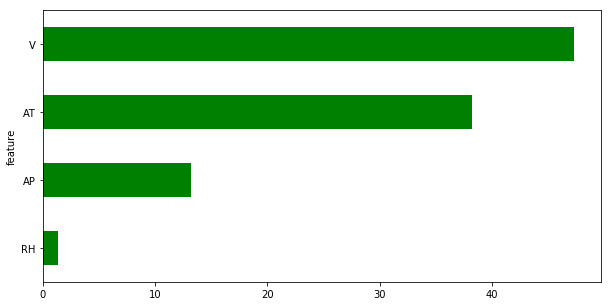

In [9]:
f_imp = pd.DataFrame({'feature':dtrain.get_feature_names(),'score':cb_mdl.feature_importance_})
f_imp = f_imp.sort_values('score',ascending=True)
f_imp[['feature','score']].head(25).plot(kind='barh', x='feature', y='score', legend=False, figsize=(10, 5),color='g')

In [10]:
def GetEvalMetrics(y_true, y_pred): 
    y_true = y_true.as_matrix()
    y_pred = y_pred.as_matrix()
    return round((1 - np.sum((y_true-y_pred)**2)/np.sum((y_true-np.mean(y_true))**2)),4), \
        round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100,4)

In [11]:
valprd = pd.DataFrame({'Actual':dval.get_label(),'Predicted':cb_mdl.predict(valx)})
_, vMAPE = GetEvalMetrics(valprd['Actual'],valprd['Predicted'])

trnprd = pd.DataFrame({'Actual':dtrain.get_label(),'Predicted':cb_mdl.predict(trainx)})
_, tMAPE = GetEvalMetrics(trnprd['Actual'],trnprd['Predicted'])

In [12]:
print('Train Metrics:\n')
print('R_Sqr: ',r2_score(trnprd['Actual'],trnprd['Predicted']))
print('RMSE: ',np.sqrt(mean_squared_error(trnprd['Actual'],trnprd['Predicted'])))
print('MAPE: ',tMAPE)
print('Mean Absult Error: ',mean_absolute_error(trnprd['Actual'],trnprd['Predicted']))
print('Median Absult Error: ',median_absolute_error(trnprd['Actual'],trnprd['Predicted']))

print('\nValdation Metrics:\n')
print('R_Sqr: ',r2_score(valprd['Actual'],valprd['Predicted']))
print('RMSE: ',np.sqrt(mean_squared_error(valprd['Actual'],valprd['Predicted'])))
print('MAPE: ',vMAPE)
print('Mean Absult Error: ',mean_absolute_error(valprd['Actual'],valprd['Predicted']))
print('Median Absult Error: ',median_absolute_error(valprd['Actual'],valprd['Predicted']))

Train Metrics:

R_Sqr:  0.996354714351
RMSE:  1.02804428521
MAPE:  0.1564
Mean Absult Error:  0.709522233168
Median Absult Error:  0.49667114566

Valdation Metrics:

R_Sqr:  0.993740319969
RMSE:  1.35735141183
MAPE:  0.2058
Mean Absult Error:  0.933366055609
Median Absult Error:  0.655453614859


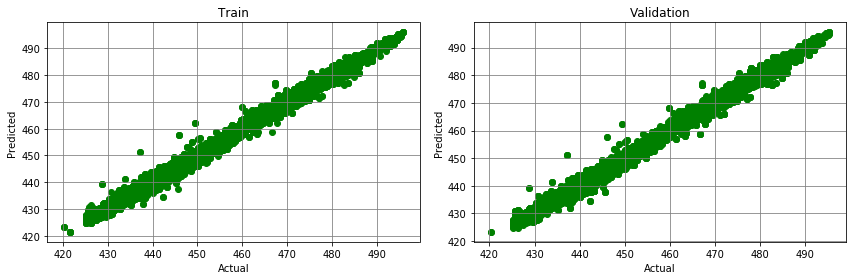

In [13]:
plt.rcParams['figure.figsize'] = (12, 4)
plt.rc('grid', linestyle="-",color='grey')
plt.subplot(1,2,1)
plt.scatter(trnprd.Actual,trnprd.Predicted,color='green')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Train')
plt.grid(True)
plt.subplot(1,2,2)
plt.scatter(valprd.Actual,valprd.Predicted,color='green')
plt.title('Validation')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.grid(True)
plt.show()

In [14]:
# Save model
cb_mdl.save_model('./catboost_model.dump')

In [15]:
# load model and score
model = CatBoostRegressor()
model.load_model('./catboost_model.dump')
model.predict(valx)

array([ 456.38446029,  427.89396632,  443.83585315, ...,  425.27470419,
        470.0004713 ,  478.97171099])